In [1]:
import os
import pickle
import torch
import torch.optim as optim
import copy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#import ccdc

#from ccdc.conformer import ConformerGenerator
from egnn_models import EGNN
from torch_geometric.nn.models import SchNet
from torch_geometric.data import Batch, DataLoader
from rdkit import Chem
from tqdm import tqdm
from rdkit.Chem.rdDistGeom import EmbedMolecule, EmbedMultipleConfs
from rdkit.Chem.PropertyMol import PropertyMol
from ConformationEnsemble import ConformationEnsembleLibrary, ConformationEnsemble
from ConfEnsembleDataset import ConfEnsembleDataset
from rdkit.Chem import AllChem #needed for rdForceFieldHelpers
from rdkit.Chem.rdForceFieldHelpers import MMFFGetMoleculeProperties, MMFFGetMoleculeForceField
from rdkit.Chem.rdDistGeom import EmbedMolecule, EmbedMultipleConfs
from torch_geometric.data import DataLoader
from collections import defaultdict
from torch.utils.tensorboard import SummaryWriter

# Data preparation

In [14]:
Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps)

In [15]:
pdbbind_dir = '/home/baillifb/v2019-other-PL/'

In [19]:
widths = [6,6,7,6,17,9,200]
cols = 'PDB code, resolution, release year, -logKd/Ki, Kd/Ki, reference, ligand name'.replace(', ', ',').split(',')
pl_data = pd.read_fwf(f'{pdbbind_dir}index/INDEX_general_PL_data.2019', widths=widths, skiprows=6, header=None)
pl_data.columns=cols

In [21]:
pl_data = pl_data[~pl_data['ligand name'].str.contains('-mer')]

In [22]:
pl_data.shape

(15304, 7)

In [23]:
pdb_ids = pl_data['PDB code'].values
#pdb_ids = sorted([dir for dir in os.listdir(pdbbind_dir) if len(dir) == 4])

In [24]:
mols = []
for pdb_id in pdb_ids :
    mol = None
    try :
        mol = Chem.rdmolfiles.MolFromMol2File(f'{pdbbind_dir}{pdb_id}/{pdb_id}_ligand.mol2', removeHs=False)
        if mol is not None :
            rdmol = Chem.MolFromSmiles(Chem.MolToSmiles(mol))
            if rdmol is not None :
                #mol = PropertyMol(mol)
                mol.GetConformer().SetProp('PDB_ID', pdb_id)
                mols.append(mol)
    except :
        print('Impossible to read mol2 file for ' + pdb_id)

Impossible to read mol2 file for 1d2v
Impossible to read mol2 file for 1jou
Impossible to read mol2 file for 1s8j
Impossible to read mol2 file for 1cam
Impossible to read mol2 file for 5y79
Impossible to read mol2 file for 2adj
Impossible to read mol2 file for 6eu6
Impossible to read mol2 file for 3b5y
Impossible to read mol2 file for 4mdm
Impossible to read mol2 file for 4lz9
Impossible to read mol2 file for 3h1k
Impossible to read mol2 file for 5oqt
Impossible to read mol2 file for 1z9j
Impossible to read mol2 file for 3b5d
Impossible to read mol2 file for 3b62
Impossible to read mol2 file for 4mdl
Impossible to read mol2 file for 4mdg
Impossible to read mol2 file for 4q78
Impossible to read mol2 file for 1h9s
Impossible to read mol2 file for 1ztz
Impossible to read mol2 file for 1hpb
Impossible to read mol2 file for 1e59
Impossible to read mol2 file for 1lr8
Impossible to read mol2 file for 4cpa
Impossible to read mol2 file for 3i8w
Impossible to read mol2 file for 5e7v


In [25]:
len(mols)

13584

In [28]:
with open('pdbbind_mol_list.p', 'wb') as f :
    pickle.dump(mols, f)

In [5]:
with open('pdbbind_mol_list.p', 'rb') as f :
    mols = pickle.load(f)

In [6]:
mol = Chem.RemoveHs(mols[0])

In [7]:
mol.GetConformers()[0].GetPositions()

array([[ 6.375, 32.307,  2.419],
       [ 7.556, 31.784,  1.576],
       [ 8.613, 32.46 ,  1.6  ],
       [ 7.394, 30.72 ,  0.928],
       [ 6.378, 31.652,  3.803],
       [ 7.731, 31.739,  4.512],
       [ 7.929, 33.069,  5.244],
       [ 9.066, 33.252,  5.717],
       [ 6.972, 33.88 ,  5.285],
       [ 4.486, 32.687,  0.854],
       [ 3.269, 32.226,  0.346],
       [ 4.936, 33.743,  0.421],
       [ 5.095, 31.955,  1.781]])

In [10]:
from rdkit.Geometry.rdGeometry import Point3D
def ccdc_conformers_to_rdkit_mol(rdkit_mol, ccdc_conformers, exclude_hydrogens=True) :
    for conformer in ccdc_conformers :
        temp_rdkit_mol = copy.deepcopy(rdkit_mol)
        new_rdkit_conf = temp_rdkit_mol.GetConformer()
        conformer_ccdc_molecule = conformer.molecule
        if exclude_hydrogens :
            conformer_ccdc_molecule.remove_hydrogens()
        for i, atom in enumerate(conformer_ccdc_molecule.atoms) :
            atom_coord = [coord for coord in atom.coordinates]
            point3d = Point3D(*atom_coord)
            new_rdkit_conf.SetAtomPosition(i, point3d)
        rdkit_mol.AddConformer(new_rdkit_conf, assignId=True)

In [11]:
from ccdc.molecule import Molecule
from ccdc.conformer import ConformerGenerator
mol2_block = Chem.MolToMolBlock(mol)
            
ccdc_conformer_generator = ConformerGenerator()
ccdc_mol = Molecule.from_string(mol2_block)
ccdc_conformer_generator.settings.max_conformers = 49
ccdc_conformers = ccdc_conformer_generator.generate(ccdc_mol)

ccdc_conformers_to_rdkit_mol(mol, ccdc_conformers)

INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul


AttributeError: 'Molecule' object has no attribute 'remove_atom'

In [13]:
type(ccdc_mol._molecule)

ChemistryLib.EditableMolecule

In [20]:
for conformer in ccdc_conformers :
    a = conformer.molecule.atoms

In [23]:
ccdc_mol.atoms

[Atom(C1),
 Atom(C2),
 Atom(O3),
 Atom(O4),
 Atom(C5),
 Atom(C6),
 Atom(C7),
 Atom(O8),
 Atom(O9),
 Atom(C10),
 Atom(C11),
 Atom(O12),
 Atom(N13)]

In [30]:
conf_ensemble_library = ConformationEnsembleLibrary(mols)

100%|███████████████████████████████████| 13584/13584 [00:01<00:00, 8134.72it/s]


In [31]:
with open('data/raw/pdbbind_conf_ensemble_library.p', 'wb') as f :
    pickle.dump(conf_ensemble_library, f)

In [57]:
with open('data/raw/pdbbind_conf_ensemble_library.p', 'rb') as f :
    conf_ensemble_library = pickle.load(f)

In [2]:
%%time
dataset = ConfEnsembleDataset('data/')

INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
Processing...


  5%|██▏                                      | 52/1000 [00:21<02:39,  5.94it/s]

14.908618418577724
OC[C@H]1O[C@@H]2O[C@@H]3[C@@H](CO)O[C@H](O[C@@H]4[C@@H](CO)O[C@H](O[C@@H]5[C@@H](CO)O[C@H](O[C@@H]6[C@@H](CO)O[C@H](O[C@@H]7[C@@H](CO)O[C@H](O[C@H]1[C@H](O)[C@H]2O)[C@H](O)[C@H]7O)[C@H](O)[C@H]6O)[C@H](O)[C@H]5O)[C@H](O)[C@H]4O)[C@H](O)[C@H]3O
14.885797294585476
OC[C@H]1O[C@@H]2O[C@@H]3[C@@H](CO)O[C@H](O[C@@H]4[C@@H](CO)O[C@H](O[C@@H]5[C@@H](CO)O[C@H](O[C@@H]6[C@@H](CO)O[C@H](O[C@@H]7[C@@H](CO)O[C@H](O[C@H]1[C@H](O)[C@H]2O)[C@H](O)[C@H]7O)[C@H](O)[C@H]6O)[C@H](O)[C@H]5O)[C@H](O)[C@H]4O)[C@H](O)[C@H]3O
14.908614065950449
OC[C@H]1O[C@@H]2O[C@@H]3[C@@H](CO)O[C@H](O[C@@H]4[C@@H](CO)O[C@H](O[C@@H]5[C@@H](CO)O[C@H](O[C@@H]6[C@@H](CO)O[C@H](O[C@@H]7[C@@H](CO)O[C@H](O[C@H]1[C@H](O)[C@H]2O)[C@H](O)[C@H]7O)[C@H](O)[C@H]6O)[C@H](O)[C@H]5O)[C@H](O)[C@H]4O)[C@H](O)[C@H]3O
14.910535619588835
OC[C@H]1O[C@@H]2O[C@@H]3[C@@H](CO)O[C@H](O[C@@H]4[C@@H](CO)O[C@H](O[C@@H]5[C@@H](CO)O[C@H](O[C@@H]6[C@@H](CO)O[C@H](O[C@@H]7[C@@H](CO)O[C@H](O[C@H]1[C@H](O)[C@H]2O)[C@H](O)[C@H]7O)[C@H](O)[C@H

  5%|██▏                                      | 53/1000 [00:24<12:26,  1.27it/s]

14.885371412061989
OC[C@H]1O[C@@H]2O[C@@H]3[C@@H](CO)O[C@H](O[C@@H]4[C@@H](CO)O[C@H](O[C@@H]5[C@@H](CO)O[C@H](O[C@@H]6[C@@H](CO)O[C@H](O[C@@H]7[C@@H](CO)O[C@H](O[C@H]1[C@H](O)[C@H]2O)[C@H](O)[C@H]7O)[C@H](O)[C@H]6O)[C@H](O)[C@H]5O)[C@H](O)[C@H]4O)[C@H](O)[C@H]3O
14.90349098701438
OC[C@H]1O[C@@H]2O[C@@H]3[C@@H](CO)O[C@H](O[C@@H]4[C@@H](CO)O[C@H](O[C@@H]5[C@@H](CO)O[C@H](O[C@@H]6[C@@H](CO)O[C@H](O[C@@H]7[C@@H](CO)O[C@H](O[C@H]1[C@H](O)[C@H]2O)[C@H](O)[C@H]7O)[C@H](O)[C@H]6O)[C@H](O)[C@H]5O)[C@H](O)[C@H]4O)[C@H](O)[C@H]3O


 32%|████████████▊                           | 319/1000 [02:17<07:56,  1.43it/s]

INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul


 32%|████████████▉                           | 323/1000 [02:18<03:35,  3.14it/s]

Error for smiles :[H]O[B+]C([H])([H])C([H])([H])[H]
Pre-condition Violation
	
	Violation occurred on line 60 in file Code/GraphMol/Conformer.cpp
	Failed Expression: dp_mol->getNumAtoms() == d_positions.size()
	RDKIT: 2020.09.1
	BOOST: 1_73



 35%|██████████████▏                         | 354/1000 [02:26<03:37,  2.97it/s]

INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul


 36%|██████████████▏                         | 355/1000 [02:26<03:16,  3.28it/s]

INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul


 37%|██████████████▋                         | 367/1000 [02:31<02:03,  5.12it/s]

INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul


 37%|██████████████▊                         | 369/1000 [02:32<02:00,  5.22it/s]

INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul


 50%|███████████████████▊                    | 495/1000 [03:36<10:28,  1.25s/it]

INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
1.2284624511831224
[Cl+]1C2C13[Cl+]C3C21C23Cl4Cl2C413


 59%|███████████████████████▌                | 589/1000 [04:29<01:22,  4.96it/s]

Error for smiles :[H]c1c([H])c([H])c2c(c1[H])Sc1c([H])c([H])c(Cl)c([H])c1N2C([H])([H])C([H])([H])C([H])([H])[N+](C([H])([H])[H])C([H])([H])[H]
Pre-condition Violation
	
	Violation occurred on line 60 in file Code/GraphMol/Conformer.cpp
	Failed Expression: dp_mol->getNumAtoms() == d_positions.size()
	RDKIT: 2020.09.1
	BOOST: 1_73



 66%|██████████████████████████▌             | 664/1000 [05:06<02:15,  2.47it/s]

INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul


 84%|█████████████████████████████████▍      | 835/1000 [06:59<01:58,  1.39it/s]

INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul


 87%|██████████████████████████████████▉     | 873/1000 [07:45<01:29,  1.41it/s]

INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul


 89%|███████████████████████████████████▋    | 891/1000 [08:32<01:45,  1.03it/s]

Error for smiles :[H]c1nc(N([H])[H])c(C([H])([H])C([H])([H])c2c([H])c([H])c([H])c(C([H])([H])[N+](C([H])([H])[H])C([H])([H])c3oc([H])c([H])c3[H])c2[H])c([H])c1[H]
Pre-condition Violation
	
	Violation occurred on line 60 in file Code/GraphMol/Conformer.cpp
	Failed Expression: dp_mol->getNumAtoms() == d_positions.size()
	RDKIT: 2020.09.1
	BOOST: 1_73



 91%|████████████████████████████████████▎   | 908/1000 [08:41<00:53,  1.73it/s]

INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul


100%|███████████████████████████████████████| 1000/1000 [10:19<00:00,  1.62it/s]


Done!
CPU times: user 10min 15s, sys: 5.61 s, total: 10min 21s
Wall time: 10min 21s


In [3]:
val_limit = int(len(dataset) * 0.6)
test_limit = int(len(dataset) * 0.8)

train_dataset = dataset[:val_limit]
val_dataset = dataset[val_limit:test_limit]
test_dataset = dataset[test_limit:]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Training SchNet

In [4]:
writer = SummaryWriter()

tfd_loss = False

schnet = SchNet()
if tfd_loss :
    schnet.lin2 = torch.nn.Linear(schnet.hidden_channels // 2, 2) # predict rmsd and tfd
schnet = schnet.to('cuda')
optimizer = optim.Adam(schnet.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)
leaky_relu = torch.nn.LeakyReLU()
mseloss = torch.nn.MSELoss()

def training_step(schnet, batch, tfd_loss=False) :
    batch = batch.to('cuda')
    preds = schnet(batch.x[:,56].long(), batch.pos, batch.batch)

    if tfd_loss :
        rmsd_pred = leaky_relu(preds[:, 0]) # to scale between 0 and +inf
        rmsd_loss = mseloss(rmsd_pred, batch.rmsd)
        tfd_pred = torch.sigmoid(preds[:, 1]) # to scale betwenn 0 and 1
        tfd_loss = mseloss(tfd_pred, batch.tfd)
        loss = rmsd_loss + tfd_loss * 5
        
    else :
        rmsd_pred = leaky_relu(preds) # to scale between 0 and +inf
        rmsd_loss = mseloss(rmsd_pred.squeeze(), batch.rmsd)
        loss = rmsd_loss
        
    return loss

In [5]:
for epoch in tqdm(range(100)):  # loop over the dataset multiple times

    # Training
    schnet.train()
    
    train_loss = 0
    for batch in train_loader :
        optimizer.zero_grad()
        loss = training_step(schnet, batch)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    train_loss = train_loss / len(train_loader)
    writer.add_scalar('Loss/train', train_loss, epoch)
        
    # Validation
    schnet.eval()
        
    val_loss = 0
    for batch in val_loader :
        loss = training_step(schnet, batch)
        val_loss += loss.item()
    
    val_loss = val_loss / len(val_loader)
    writer.add_scalar('Loss/val', val_loss, epoch)
    
    scheduler.step(val_loss)

torch.save(schnet, 'schnet_100epochs_limited_pdbbind')
    
print('Finished Training')

 95%|███████████████████████████████████████▉  | 95/100 [11:41<00:36,  7.38s/it]


KeyboardInterrupt: 

In [6]:
torch.save(schnet, 'schnet_95epochs_limited_pdbbind')

In [7]:
schnet = torch.load('schnet_95epochs_limited_pdbbind')

# Evaluation on test set

In [8]:
def group_data_by_smiles(data_list) :
    d = defaultdict(list)
    for data in data_list :
        d[data.smiles].append(data)
    return d

O=[N+]([O-])c1ccc(O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]2O)cc1
tensor(0.1720)


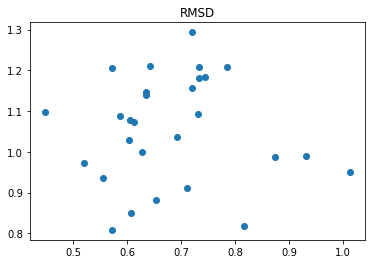

CC(=O)Nc1ccc(-c2cccc(C(=O)[O-])c2)cc1
tensor(0.1583)


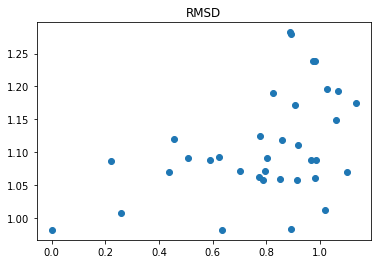

CC(C)COC[C@@H](CN(Cc1ccccc1)c1ccccc1)[NH+]1CC=CC1
tensor(0.6900)


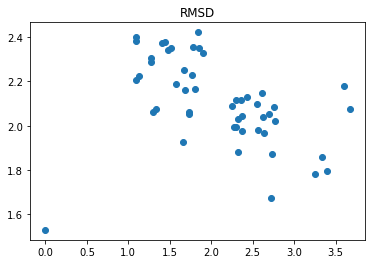

COC(=O)[C@H](Cc1cccc(C(N)=[NH2+])c1)NC(=O)CNS(=O)(=O)c1ccc(C)cc1
tensor(0.6542)


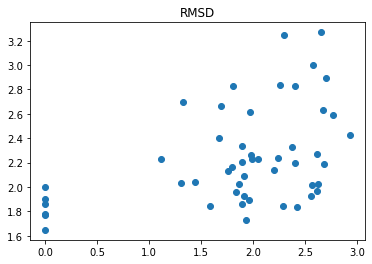

COc1ccc(CCC(=O)[O-])cc1OC
tensor(0.1396)


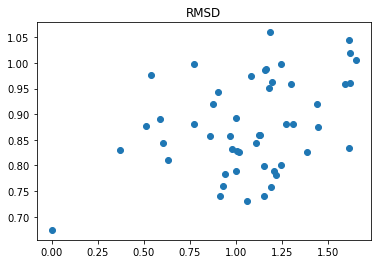

O=[N+]([O-])c1ccc(O)cc1
tensor(0.0272)


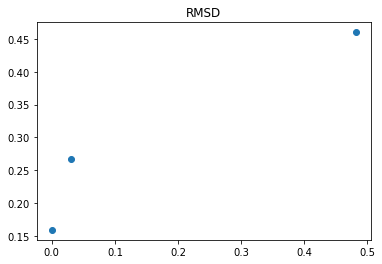

COc1ccc(CC(C(=O)[O-])C(=O)[O-])cc1OC
tensor(0.1668)


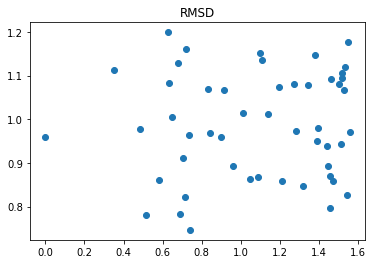

C[C@H](C(=O)[O-])c1ccc2c(c1)[nH]c1ccc(Cl)cc12
tensor(0.2691)


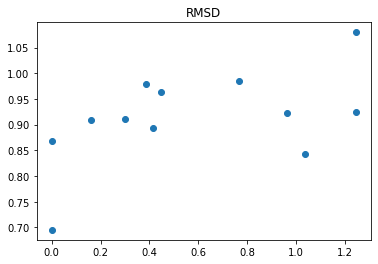

[NH3+][C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@H]1CC[N@@H+](Cc2c[nH]c3ccccc23)CC1
tensor(0.2913)


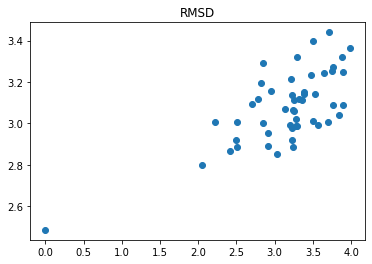

O=c1c(-c2ccc(O)c(O)c2)coc2cc(O)ccc12
tensor(0.3253)


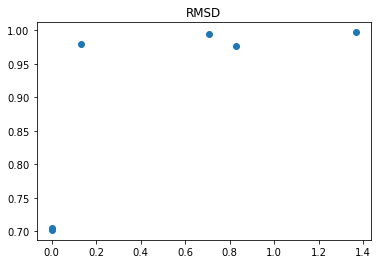

O=C([O-])c1cccc(-c2cccnc2)c1
tensor(0.2216)


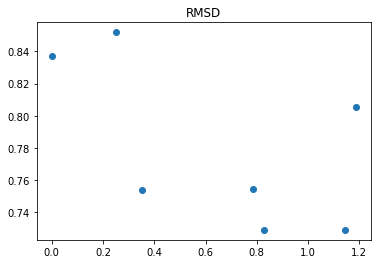

O=C([O-])c1cccc(-c2ccncc2)c1
tensor(0.2534)


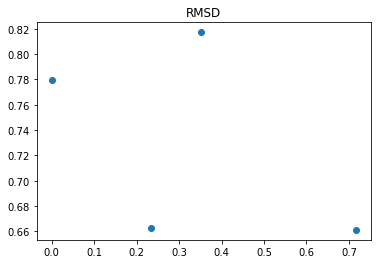

Cc1ncccc1N[C@@H]1CCCS(=O)(=O)C1
tensor(0.2028)


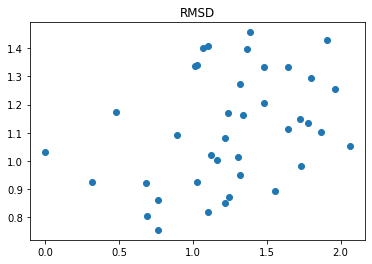

O=C([O-])c1c[nH][n+]2c(O)c(Cc3ccccc3)c(Cl)nc12
tensor(0.4336)


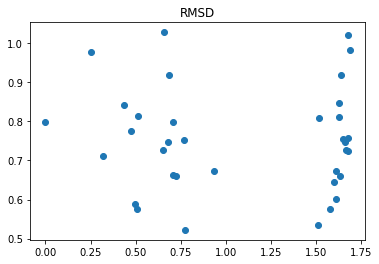

c1ccc(Cn2cnc3ncccc32)cc1
tensor(0.2247)


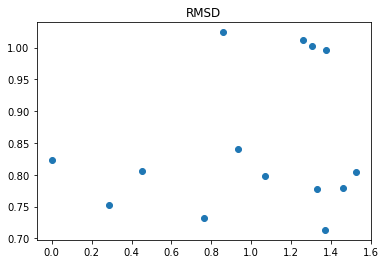

CC(C)/N=C\[C@@H](O)COc1cccc2ccccc12
tensor(0.2418)


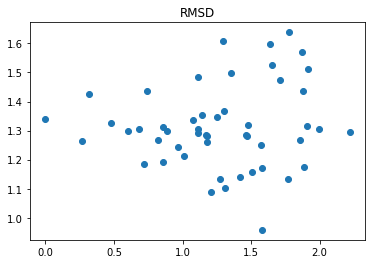

CC1=N[C@H]2[C@H](O[C@H](CO)[C@@H](O)[C@@H]2O)S1
tensor(0.1239)


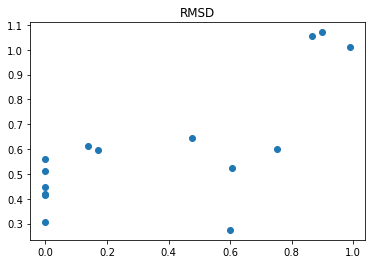

O=C([O-])COc1ccc(-c2ccc(F)cc2F)cc1
tensor(0.0829)


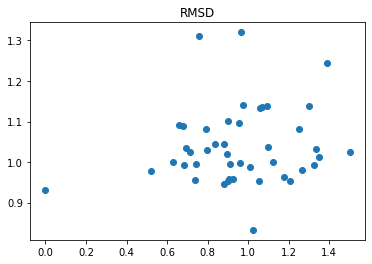

[NH2+]=c1[nH]c(O)c(CCCc2ccc(C(=O)[O-])cc2)c(=O)[nH]1
tensor(0.1414)


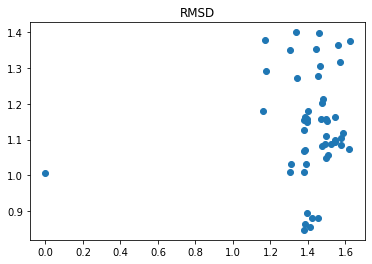

C[NH+]1CCN(c2cccc(C[NH3+])c2)CC1
tensor(0.0547)


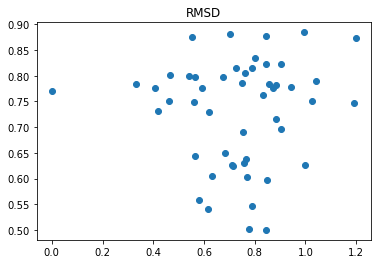

CC(C)C[C@H](CNC(=O)CCC[NH3+])Cc1ccc2c(c1C(=O)[O-])OCO2
tensor(0.6957)


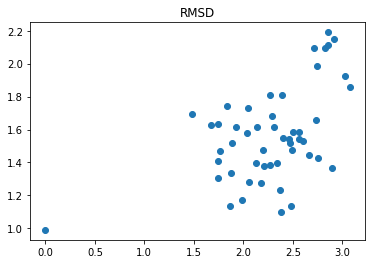

Cc1cc(C)c([C@H]2C(C(=O)c3cccs3)=C(O)C(=O)N2c2ccc(CC(=O)[O-])cc2)cc1C
tensor(0.4512)


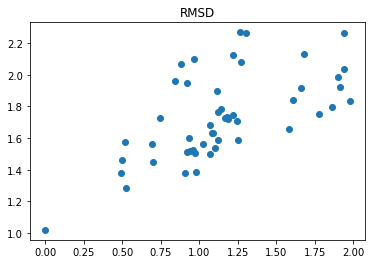

O=[N+]1C=C(C(F)(F)F)C=CC1=S
tensor(0.0456)


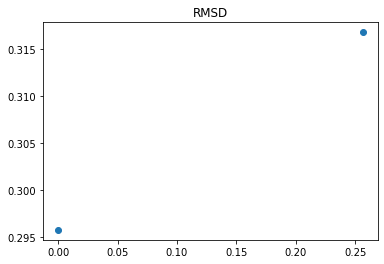

COc1cc(S(=O)(=O)N(CC(C)C)[C@@H](C(=O)NO)C(C)C)ccc1F
tensor(0.4963)


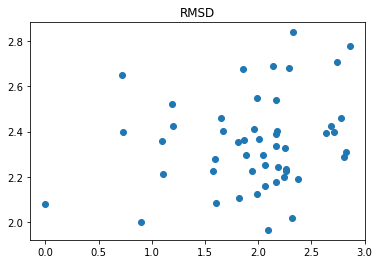

C#Cc1cc(C#CCOc2ccccc2)cc(C[N@H+]2CC[C@H]([NH+](CC)CC)CC2)c1O
tensor(0.3182)


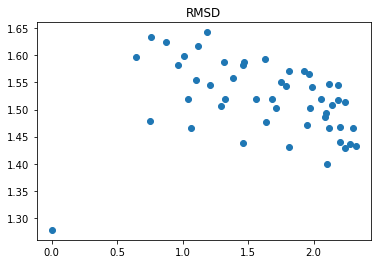

[NH3+]Cc1ccc(-c2ccccc2)c(Cl)c1
tensor(0.0700)


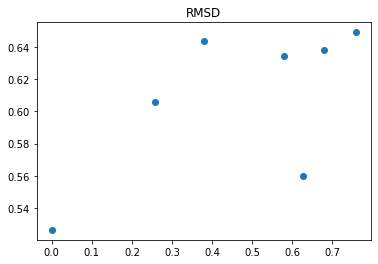

CC(C)Cc1nc(C#N)c(N)o1
tensor(0.0968)


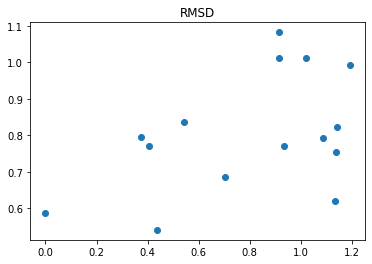

O=S(=O)([O-])c1cc(Cl)c(O)c(Cl)c1
tensor(0.0036)


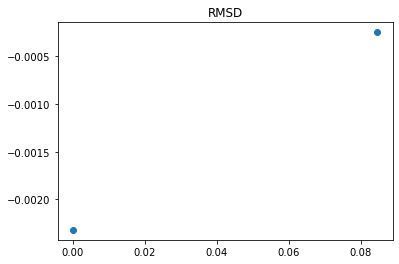

[NH3+][C@@H]1C[C@H](O)[C@H](O)[C@@H]1O
tensor(0.1036)


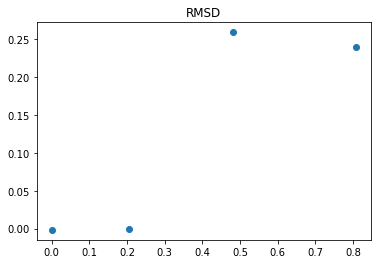

C[C@H](N=[N+2]#N)C(=O)NC[C@H]1O[C@@H](n2ccc(=O)[nH]c2=O)[C@H](O)[C@@H]1O
tensor(0.3495)


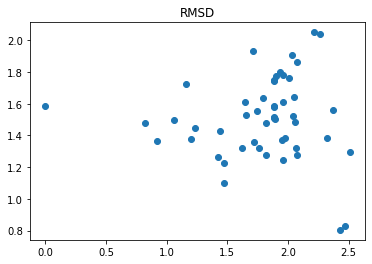

O=C(/C=C/c1ccc(F)cc1)N(C(=O)NC1CCCCC1)C1CCCCC1
tensor(0.9851)


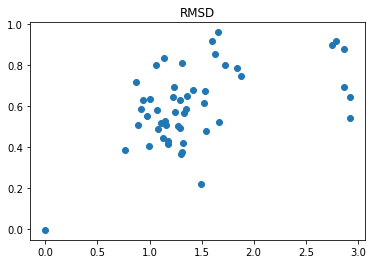

CO[C@H]1/C=C/O[C@@]2(C)Oc3c(C)c(O)c4c(O)c(c(/C=N/N5CC[NH+](C)CC5)c(O)c4c3C2=O)NC(=O)[C@H](C)CCC[C@H](C)[C@H](O)[C@@H](C)[C@@H](O)[C@@H](C)[C@H](OC(C)=O)[C@@H]1C
tensor(0.2529)


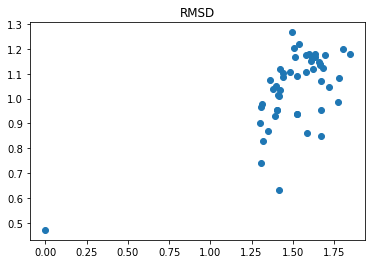

CCCN(Cc1ccc(N)cc1)C(=O)NCC(=O)OCC
tensor(0.1913)


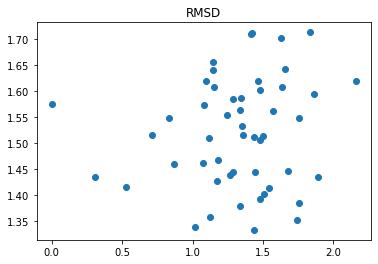

Nc1ncnc2nc[nH]c12
tensor(0.0081)


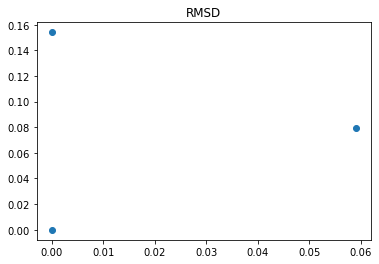

C[C@]([NH3+])(CCCCB(O)O)C(=O)[O-]
tensor(0.0949)


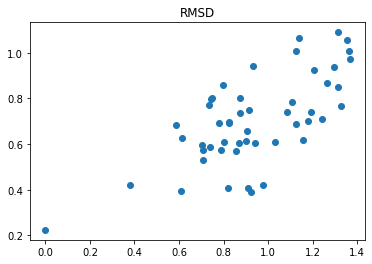

CC(C)C[C@H](CNC(=O)Cc1c[nH]c2ccccc12)Cc1ccc2c(c1C(=O)[O-])OCO2
tensor(0.8629)


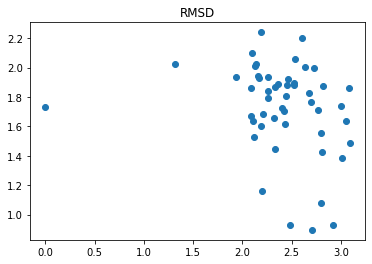

Cc1ccc(=S)n(O)c1
tensor(0.0009)


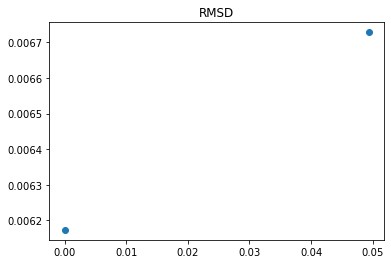

CSC[S@](C)=O
tensor(0.1148)


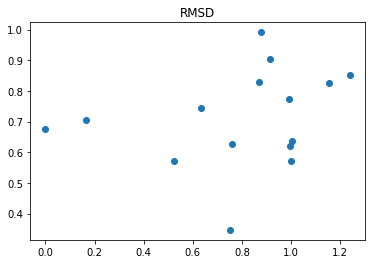

CCOP(=O)(Cc1ccc(C)cc1)OCC
tensor(0.1323)


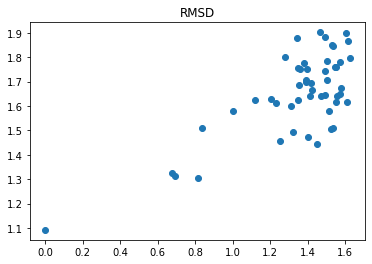

C[C@@H](Oc1ccc(Oc2ncc(C(F)(F)F)cc2Cl)cc1)C(=O)[O-]
tensor(0.2417)


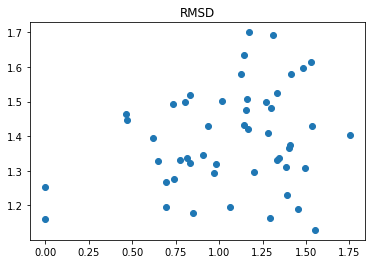

O=C([O-])CCCCO
tensor(0.0904)


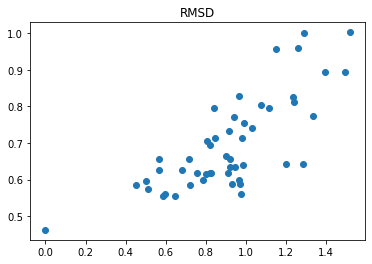

O=C([O-])CCCCCNC(=O)NC1CCCCC1
tensor(0.1062)


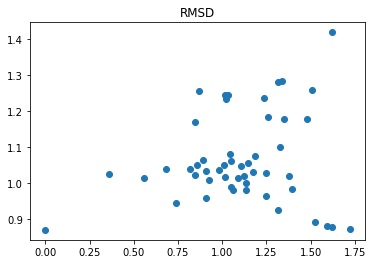

C[NH+](C)CCCN1c2ccccc2CCc2ccc(Cl)cc21
tensor(0.2228)


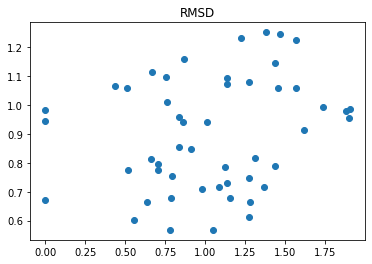

CC1[C@@H](O)[C@H](O)[C@@H](O)[C@@H]([NH2+][C@H]2[C@H](O)[C@@H](O)[C@@H](O[C@@H]3[C@@H](CO)OC[C@H](O)[C@H]3O)O[C@@H]2C)[C@@H]1O
tensor(0.5989)


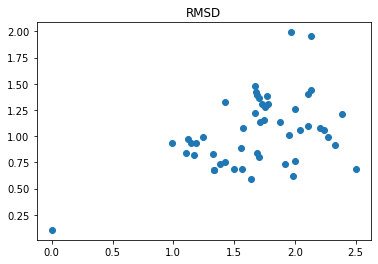

Nc1nccc(-c2cccnc2)n1
tensor(0.1894)


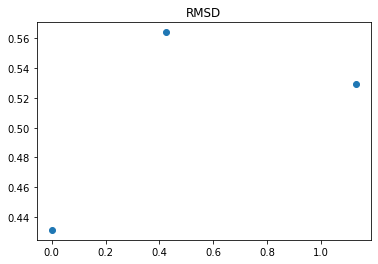

O=C([O-])/C=C/C(=N/C(=O)c1cc(CNc2ccc(/C=C3\SC(=S)NC3=O)cc2)ccc1F)C(=O)[O-]
tensor(0.8028)


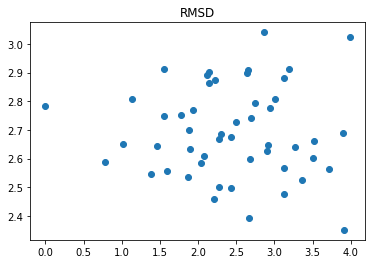

[NH3+]C(CC(=O)[O-])(CC(=O)[O-])C(=O)[O-]
tensor(0.1569)


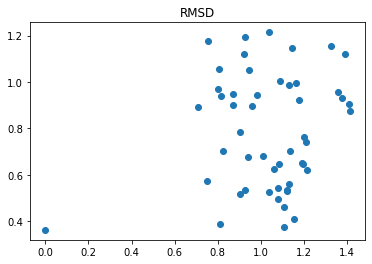

CCCC(CCC)C(N)=O
tensor(0.0638)


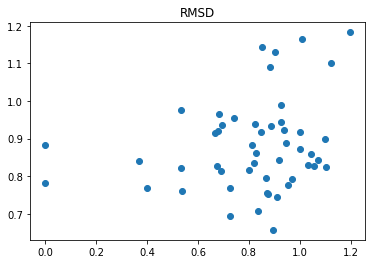

CO[C@@H](C(=O)NC1Cc2ccccc2C1)[C@H](O)[C@@H](O)[C@H](O)/C=C/C(C)(C)C
tensor(0.4163)


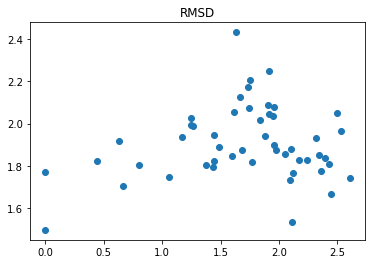

CO[C@H]1O[C@@H](C)[C@@H](O)[C@@H](O)[C@@H]1O
tensor(0.0674)


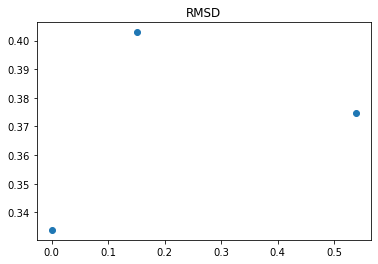

CC(=O)Nc1cccc(C2=CC(C)N(O)c3ccccc32)c1
tensor(0.9855)


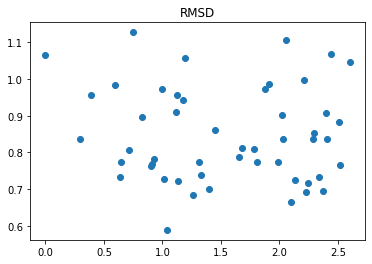

Cc1cc(-c2ccccc2)n2nc(N)nc2n1
tensor(0.1435)


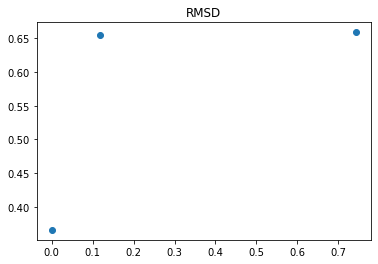

O=C([O-])COCC[N@H+]1CC[N@H+]([C@@H](c2ccccc2)c2ccc(Cl)cc2)CC1
tensor(0.5656)


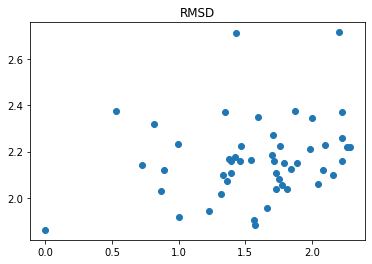

Cc1nn(-c2ccccc2)nc1C(N)=O
tensor(0.0794)


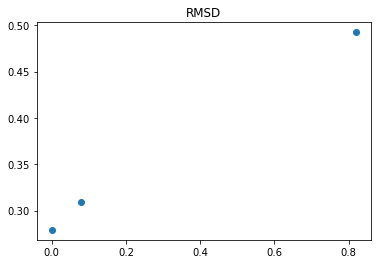

COc1ccc(-c2cccc(C(=O)[O-])c2)cc1
tensor(0.2151)


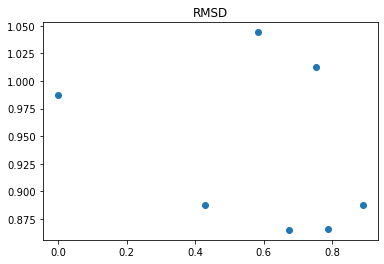

CC1=CC(=O)CC(C)(C)[C@@]1(O)/C=C/C(C)CC(=O)[O-]
tensor(0.2868)


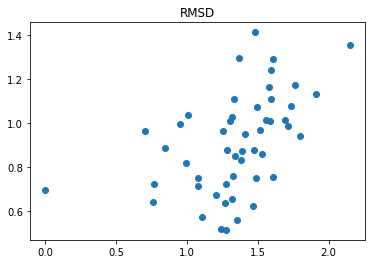

C[C@H]1O[C@@H](O)[C@H](O)[C@@H](O)[C@@H]1O[C@@H]1O[C@H](CO)[C@H](O)[C@H](O)[C@H]1O
tensor(0.1179)


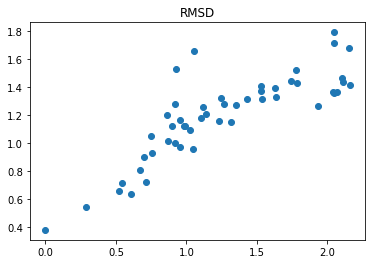

O=C(NO)c1cc2c(Cl)cccc2s1
tensor(0.2317)


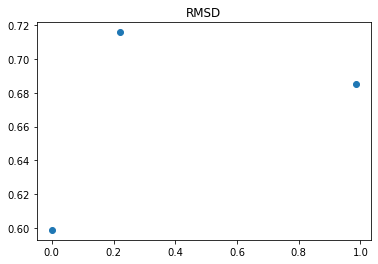

Oc1ccc(/C=C/c2cc(O)cc(O)c2)cc1
tensor(0.5224)


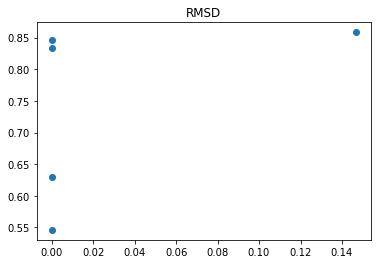

Oc1ccc(CCc2cc(O)cc(O)c2)cc1
tensor(0.2477)


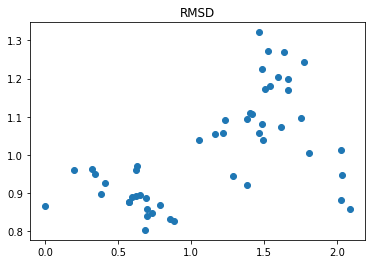

COc1ccc(CO)c2nc3cccc(C(=O)[O-])c3nc12
tensor(0.1223)


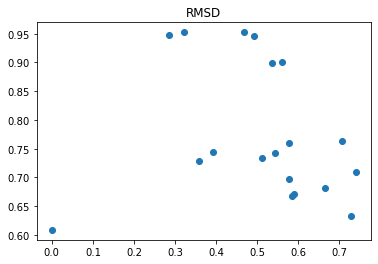

c1ccc(CNc2ncnc3nc[nH]c23)cc1
tensor(0.1088)


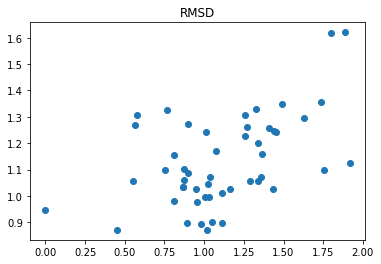

COC(=O)CCCNC(=O)c1c(C)n(C)c2ccc(OC)cc12
tensor(0.4131)


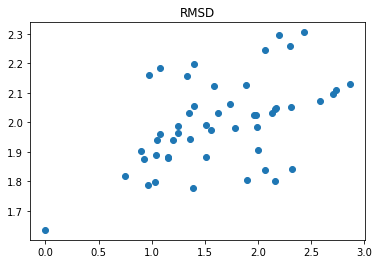

Nc1cccnc1N
tensor(3.8825e-06)


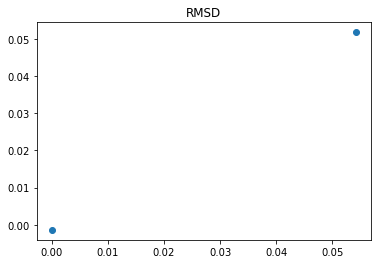

COc1ccccc1-c1ccc(C[NH3+])cc1Cl
tensor(0.4939)


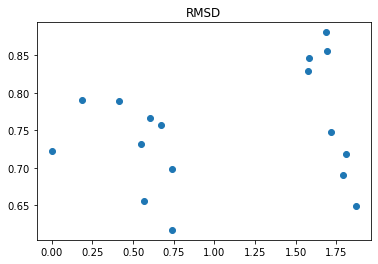

CO[C@H]1/C=C/O[C@@]2(C)Oc3c(C)c(O)c4c(O)c(cc(O)c4c3[C@H]2O)NC(=O)/C(C)=C\C=C\[C@H](C)[C@H](O)[C@@H](C)[C@@H](O)[C@@H](C)[C@H](OC(C)=O)[C@@H]1C
tensor(0.7406)


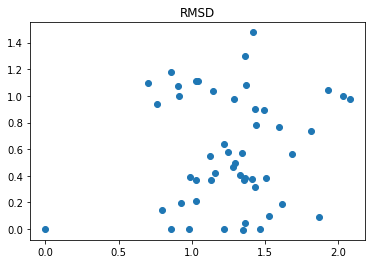

[NH3+][C@@H]1CONC1=O
tensor(0.0523)


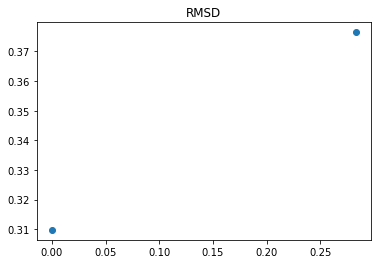

O=C([O-])c1ccc(O)cc1
tensor(0.0007)


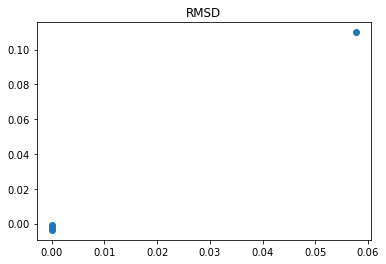

C=C(O[C@H]1C=CC=C(C(=O)[O-])C1=O)C(=O)[O-]
tensor(0.1969)


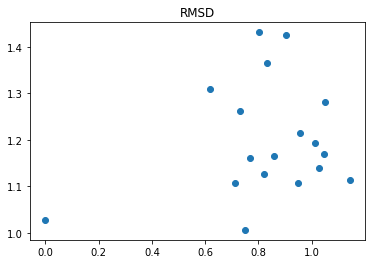

COC(=O)[C@H]1C[C@]2(C[NH2+]1)C(=O)Nc1ccccc12
tensor(0.2462)


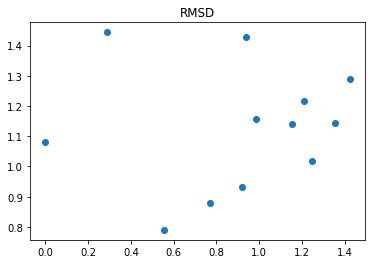

CNC(=O)[C@@H]1C[C@@H](O)CN1C(=O)Cc1cc(C)no1
tensor(0.1837)


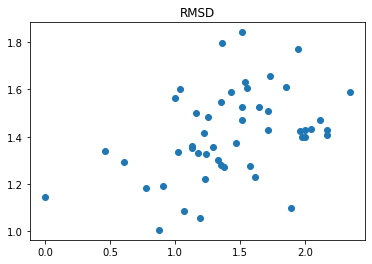

CNC(=O)c1scc2c1OCCO2
tensor(0.1296)


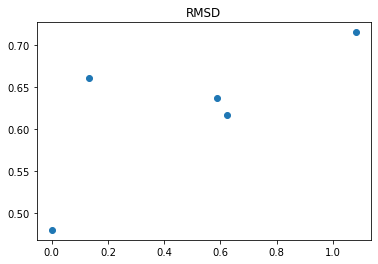

Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](NC(=O)[C@@H]([NH3+])CO)[C@H]1O
tensor(0.1548)


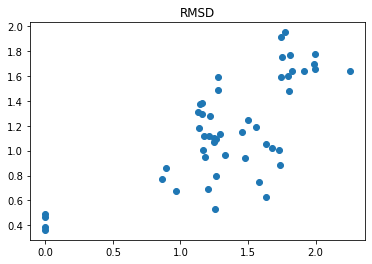

O=C[C@H](Cc1cnc[nH]1)[NH2+]C[C@H]1C[C@@H]2CCCC[C@H]2CN1C(=O)c1ccc(-c2ccccc2)cc1
tensor(0.5498)


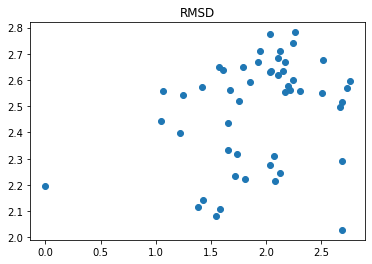

O=C([O-])c1cccc(-c2cccc(F)c2)c1
tensor(0.3037)


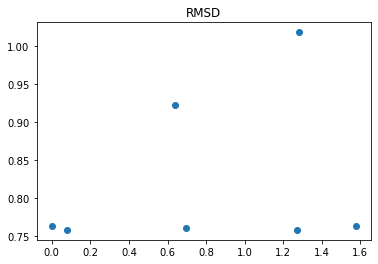

CS(=O)(=O)NCc1ccc(-c2cccc(C(=O)[O-])c2)cc1
tensor(0.2310)


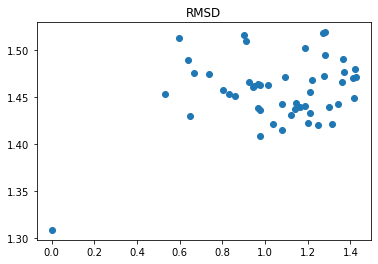

c1ccn(CCOc2ccc3[nH]ccc3c2)c1
tensor(0.1897)


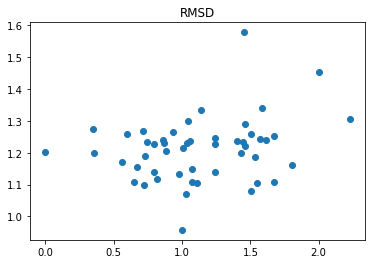

[NH3+]Cc1csc(-c2cccs2)n1
tensor(0.3922)


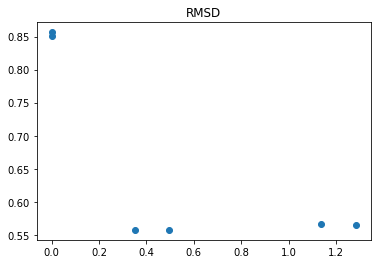

C[NH+](C)C[C@@H](c1ccc(O)cc1)C1(O)CCCCC1
tensor(0.1499)


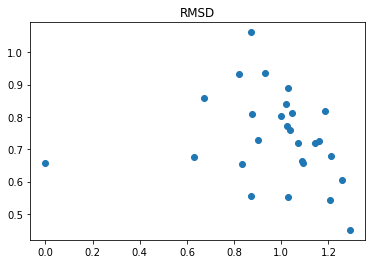

O=C([O-])c1ccccc1Nc1cccc(Br)c1
tensor(0.3810)


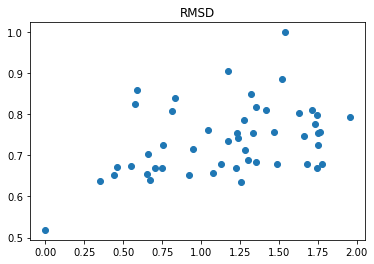

[NH3+]Cc1ccc(-c2ccccc2F)c(Cl)c1
tensor(0.4437)


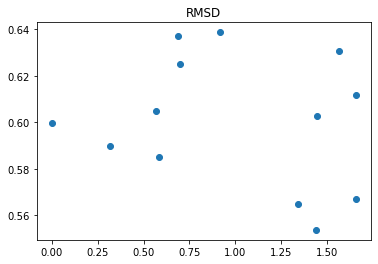

O=C([O-])/C(F)=C\c1ccc(O)cc1
tensor(0.2516)


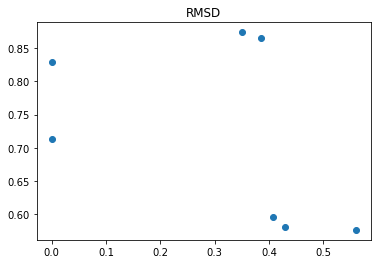

COc1cc(C)c2ccc(O)c(C(=O)O[C@@H]3[C@@H](O)C=C[C@H]3O)c2c1
tensor(0.1217)


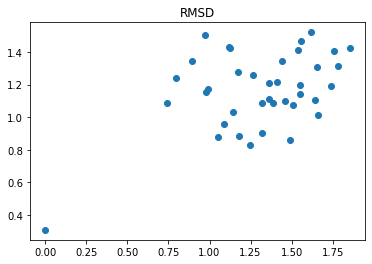

O=C([O-])COc1c(C(=O)[O-])sc2ncccc12
tensor(0.1592)


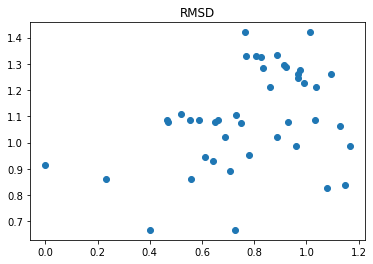

CCN(CC)C(=O)[C@@H]1OC(C(=O)[O-])=C[C@H]([NH3+])[C@H]1NC(C)=O
tensor(0.1662)


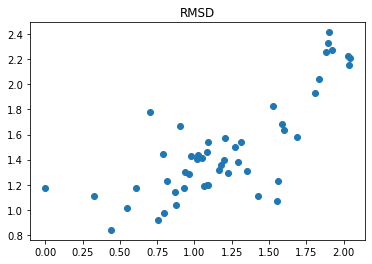

[NH2+]=c1[nH]c(=O)c2ncc(C(=O)[O-])nc2[nH]1
tensor(0.5827)


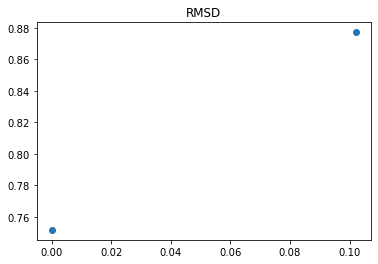

CC(=O)N1CCC(C(=O)Nc2ccc(C)cn2)CC1
tensor(0.2239)


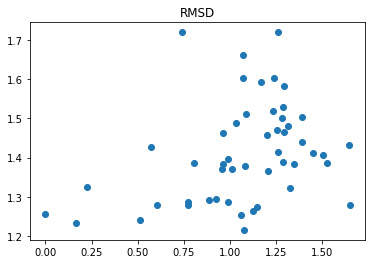

O=C([O-])[C@]1(O)C[C@@H](O)[C@@H](O)[C@H](O)C1
tensor(0.1206)


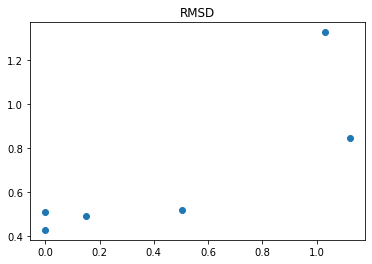

O=C([O-])c1cccc(-c2cccc(CO)c2)c1
tensor(0.3269)


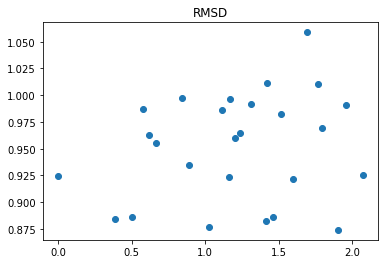

Oc1cccc2nc(C(F)(F)F)[nH]c12
tensor(0.4708)


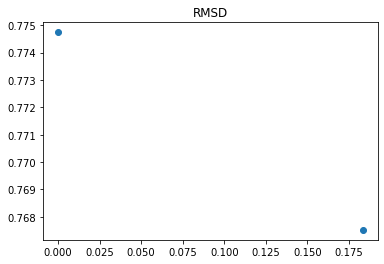

CCC(CC)Nc1cc(C(=O)[O-])ccc1N1C(=O)CCC1(CO)CO
tensor(0.4683)


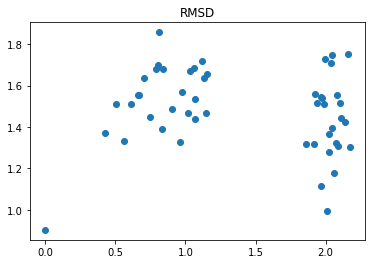

Cc1oc2ccc(NS(=O)(=O)c3ccc(Cl)cc3)cc2c1C(=O)[O-]
tensor(0.4745)


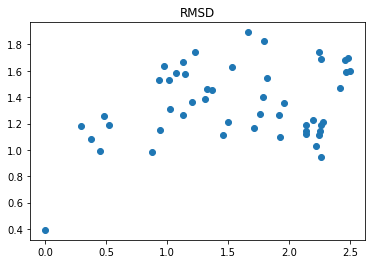

C[NH+](C)Cc1cc(I)cc(I)c1O
tensor(0.1466)


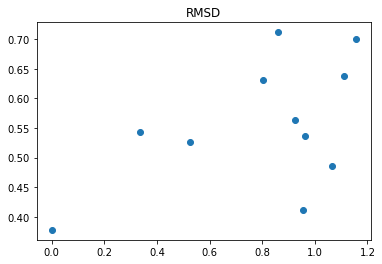

C[C@@H]([NH3+])C(=O)[O-]
tensor(0.1081)


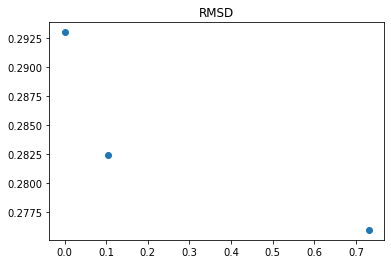

COC(=O)CCC(=O)OC
tensor(0.2224)


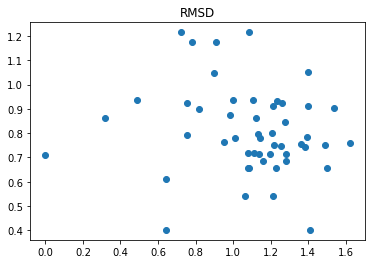

COc1cccc(-c2cccc(C(=O)[O-])c2)c1
tensor(0.2770)


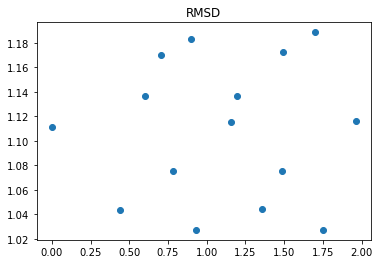

O=C([O-])CCCCCCCCC(=O)[O-]
tensor(0.5844)


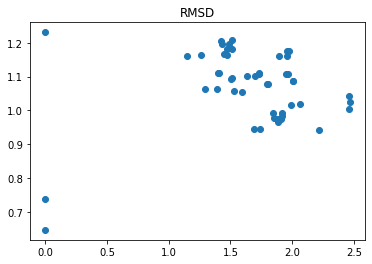

Nc1nc(CCc2ccccc2)cc(=O)[nH]1
tensor(0.3384)


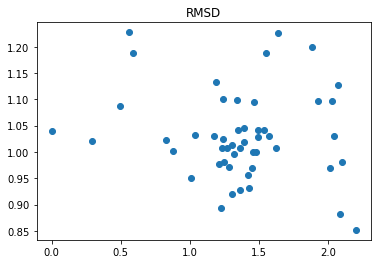

[NH3+]CCc1ccc(O)c(C2CCCCC2)c1
tensor(0.0258)


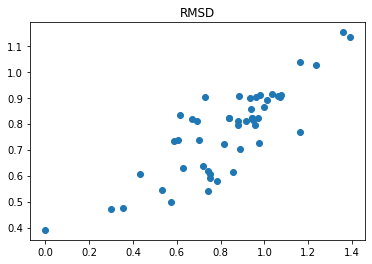

[NH2+]=c1[nH]c(=O)c2cc[nH]c2[nH]1
tensor(0.0451)


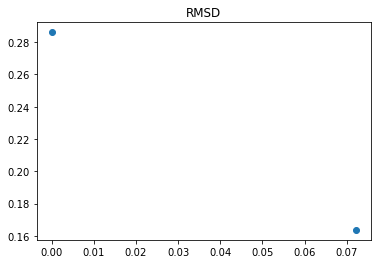

CC(=O)N[C@H]1[C@H](Oc2ccc([N+](=O)[O-])cc2)O[C@H](CO)[C@@H](O)[C@@H]1O
tensor(0.0574)


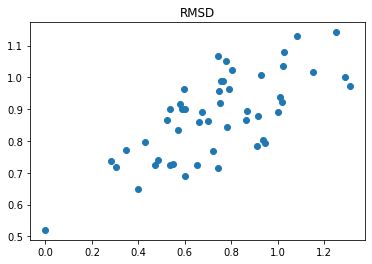

O=C([O-])CCn1nc(-c2cccnc2)ccc1=O
tensor(0.1238)


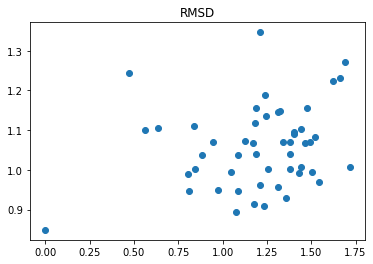

CCC(CC)O[C@@H]1C=C(C(=O)[O-])C[C@H]([NH3+])[C@H]1NC(C)=O
tensor(0.6540)


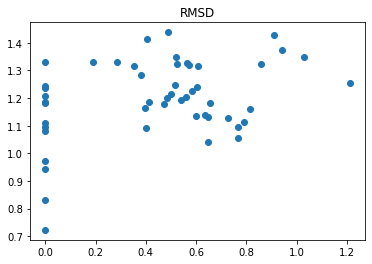

CN(C)c1cccc(-c2cccc(C(=O)[O-])c2)c1
tensor(0.3096)


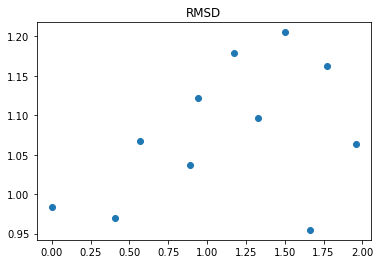

CCC(=O)N[C@@H]1[C@@H](O)C[C@](OCc2ccccc2)(C(=O)[O-])O[C@H]1[C@H](O)[C@H](O)CO
tensor(0.3161)


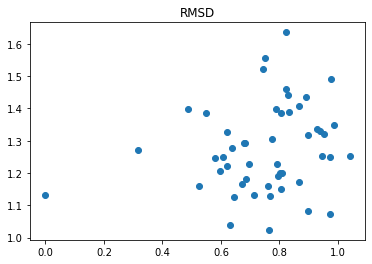

CN1C[C@@H](CC(C)(C)O)N=C2C(=O)NC(=[NH2+])N=C21
tensor(0.1513)


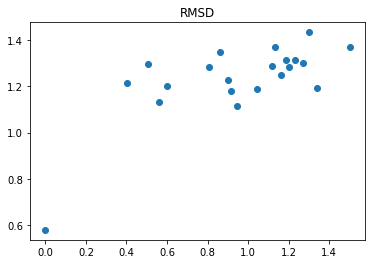

[H]/N=C1\N=C2NC[C@@H](C)N=C2C(=O)N1
tensor(0.6053)


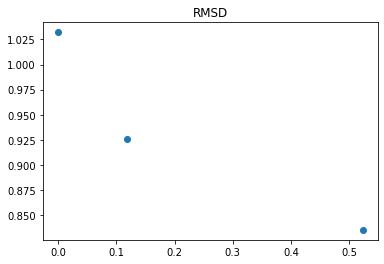

COc1ccc(CNC(=O)c2cc3ccccc3cc2C[N@@H+](C)Cc2cccc(OC)c2C(=O)[O-])cc1
tensor(0.3198)


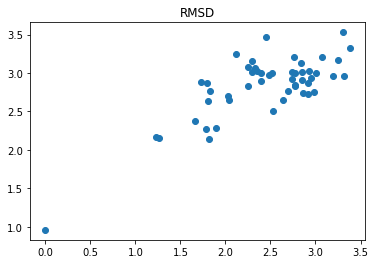

Cc1ccc(N2C(=O)C(O)=C(C(=O)c3ccccc3)[C@@H]2c2cc(Br)cs2)cc1C(=O)[O-]
tensor(0.4919)


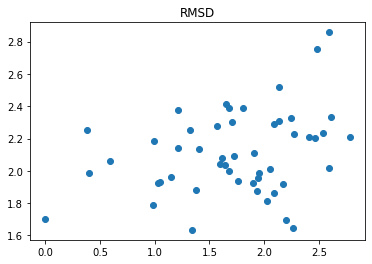

CCC(CC)O[C@@H]1C[C@H](C(=O)[O-])C[C@H]([NH3+])[C@H]1NC(C)=O
tensor(0.1925)


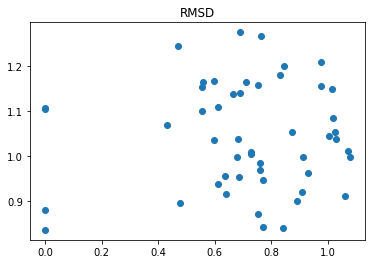

O=C([O-])c1cc2[nH]c3ccccc3c2cc1Cl
tensor(0.2096)


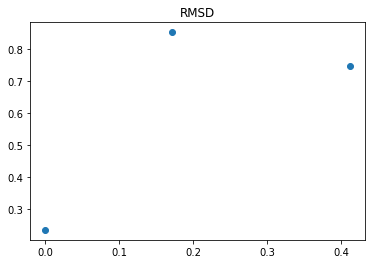

CC[n+]1c(-c2ccccc2)c2cc(N)ccc2c2ccc(N)cc21
tensor(0.0995)


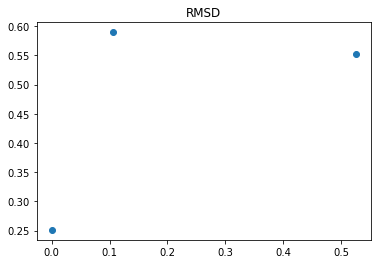

[H]/N=c1/nc[nH]c2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1NC(=O)[C@@H]([NH3+])CCC
tensor(0.1648)


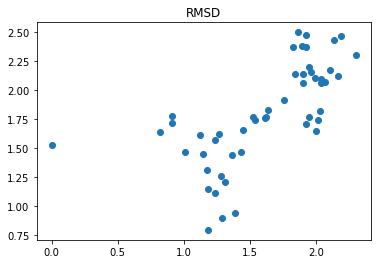

CC[C@H](C)[C@H]([NH3+])C(=O)N[C@@H]1[C@H](O)[C@@H](CO)O[C@H]1n1cnc2c(N)ncnc21
tensor(0.1408)


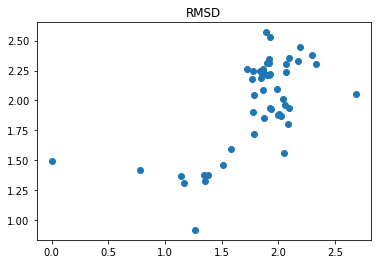

CCOc1ccc(NC(C)=O)cc1Cl
tensor(0.0971)


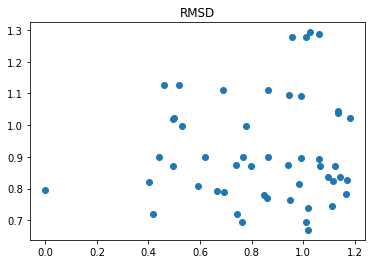

Nc1nc2[nH]c(I)nc2c(=O)[nH]1
tensor(0.2619)


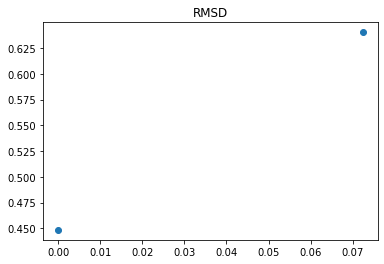

Nc1ncnc2c1ncn2[C@@H]1O[C@H](CSSCc2ccccc2)[C@@H](O)[C@H]1O
tensor(0.2551)


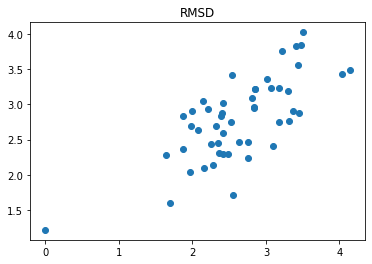

COc1ccc2[nH]c(C(=O)NS(C)(=O)=O)cc2c1
tensor(0.0737)


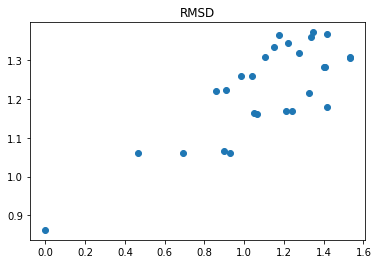

Nc1nc2c(c(=O)[nH]1)N(C=O)[C@@H](CNc1ccc(C(=O)N[C@@H](CCC(=O)[O-])C(=O)[O-])cc1)CN2
tensor(0.5144)


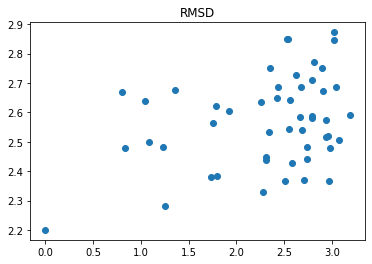

O=C([O-])C(Oc1ccc(Br)cc1)C(=O)[O-]
tensor(0.2186)


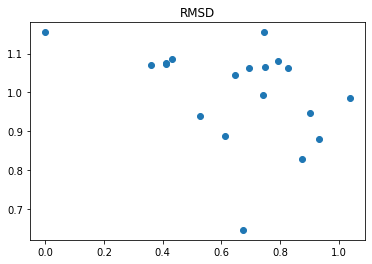

O=C([O-])C[C@@]12O[C@H]3C=CC[NH2+][C@H]3[C@@H]1C(=O)N[C@H]2C(=O)[O-]
tensor(0.6534)


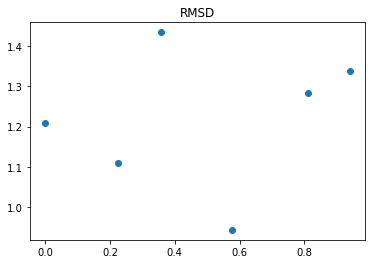

[NH2+]=c1[nH]c(=O)c2ncc(C(=O)NCCNC(=O)Nc3ccccc3)nc2[nH]1
tensor(0.9439)


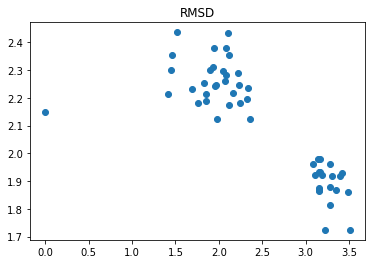

COc1ccc(CC(=O)[O-])cc1-c1ccccc1
tensor(0.0679)


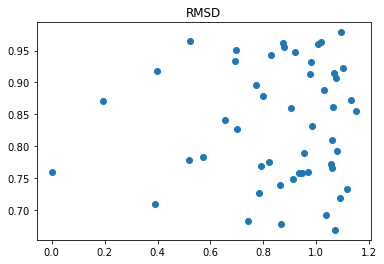

CC(=O)N[C@H]1[C@H](O[C@H]2C[C@@H](C(=O)NCCS(=O)(=O)[O-])[NH2+][C@@H]2CO)O[C@H](CO)[C@@H](OS(=O)(=O)[O-])[C@@H]1O
tensor(0.6707)


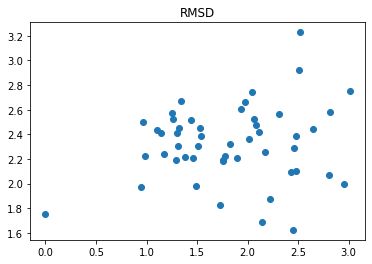

Nc1nc2c(ncn2[C@H]2C[C@H](O)[C@@H](CO)O2)c(=O)[nH]1
tensor(0.2816)


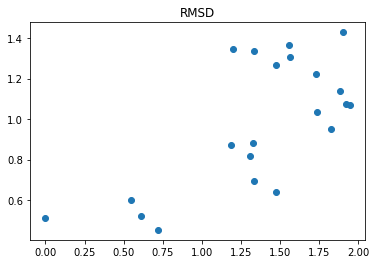

O=c1ccn([C@@H]2O[C@@H](C[NH+]3CCCC3)[C@H](O)[C@H]2O)c(=O)[nH]1
tensor(0.2339)


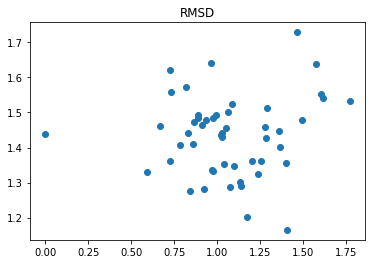

CC(=O)N[C@H]1[C@H](O)O[C@H](CO)[C@@H](O[C@@H]2O[C@H](CO)[C@H](O)[C@H](O)[C@H]2O[C@@H]2O[C@@H](C)[C@@H](O)[C@@H](O)[C@@H]2O)[C@@H]1O[C@@H]1O[C@@H](C)[C@@H](O)[C@@H](O)[C@@H]1O
tensor(0.2271)


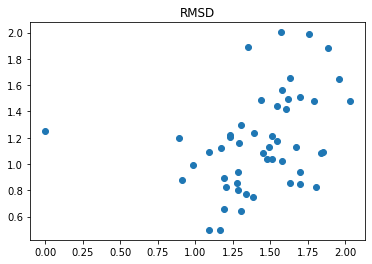

NC(=O)Cn1c2c(c3cc(Cl)ccc31)CC[C@@H](C(=O)[O-])C2
tensor(0.2329)


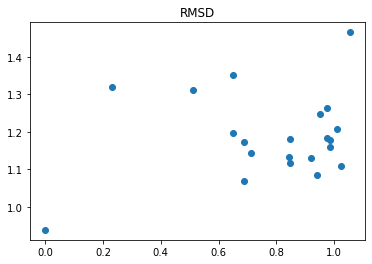

COC(=O)c1cc(N)cc(-c2c(C)noc2C)c1
tensor(0.4342)


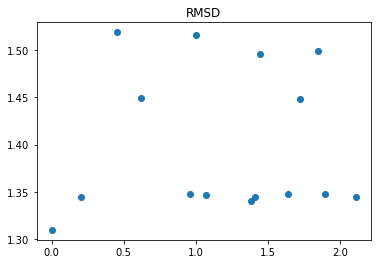

Nc1nonc1-c1ccccc1
tensor(0.3258)


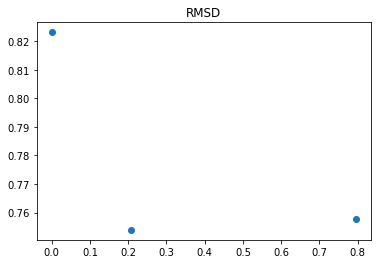

c1c[nH]c(-c2ccc(OCCCCCCCOc3ccc(-c4ncc[nH]4)cc3)cc2)n1
tensor(0.3682)


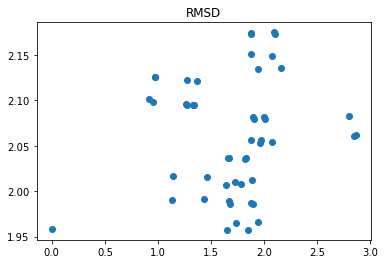

CC(C)c1ccccc1-c1ccc(C[NH3+])cc1Cl
tensor(0.5717)


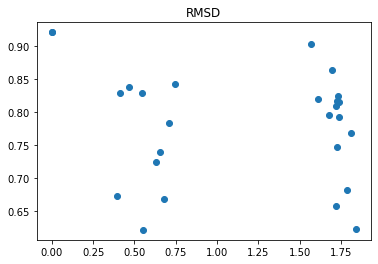

[H]/N=C/c1nccc(CNC(=O)[C@@H](NC(=O)[C@H](c2cc(Cl)cc(Cl)c2)[NH+](C)C)[C@@H](C)CC)n1
tensor(1.2486)


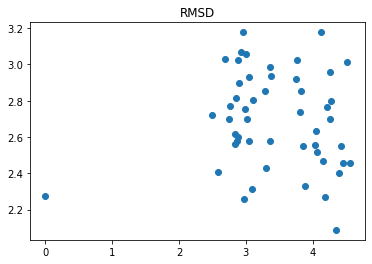

CC[C@H](C=O)[C@@H](CNS(=O)(=O)c1ccc([N+](=O)[O-])cc1)C(=O)[O-]
tensor(0.2718)


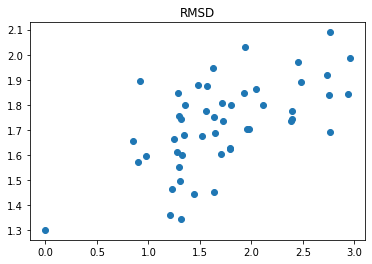

CCCCn1c(Cc2cc(OC)c(OC)c(OC)c2)nc2c(N)ncnc21
tensor(0.1996)


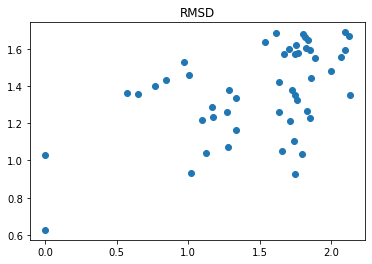

CCCCn1c(Cc2ccc(OC)cc2)nc2c(N)ncnc21
tensor(0.2550)


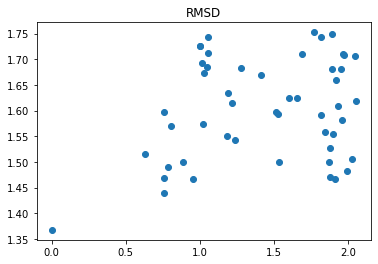

CCCCn1c(Cc2cc(OC)c(OC)c(OC)c2Cl)nc2c(N)ncnc21
tensor(0.6297)


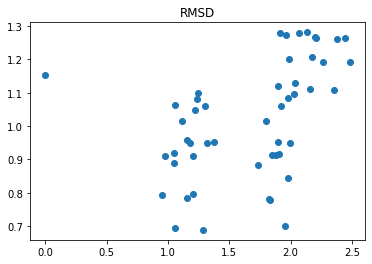

C#CCCCn1c(Cc2cc(OC)c(OC)c(OC)c2Cl)nc2c(N)ncnc21
tensor(0.2549)


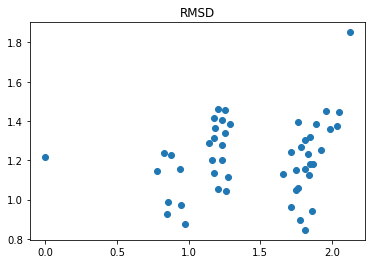

O=C([O-])C[C@@H](Cc1ccccc1)C(=O)[O-]
tensor(0.1531)


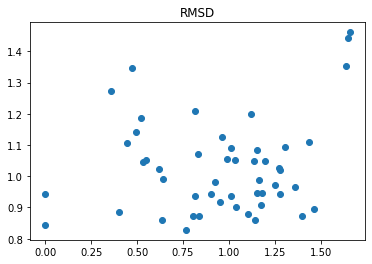

Oc1c2ccccc2cc2ccccc12
tensor(0.1766)


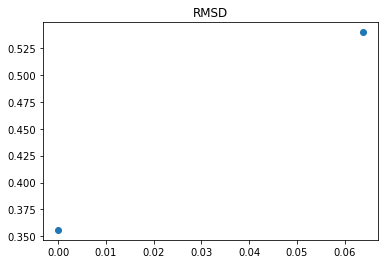

CO[C@H]1O[C@H](CO)[C@@H](O)[C@H](O[C@@H]2OC[C@@H](O)[C@H](O)[C@H]2O)[C@@H]1O
tensor(0.0894)


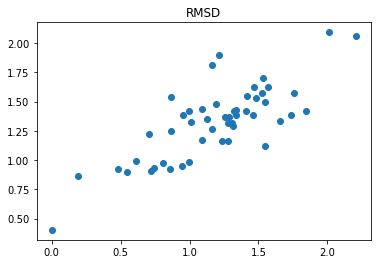

NC(=[NH2+])Nc1ccc(C[C@H](NC(=O)CSc2ccc(Cl)cc2)C(N)=O)cc1
tensor(0.8379)


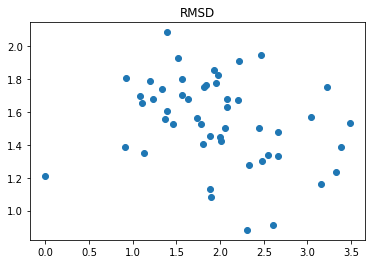

Nc1nc2ccccc2[nH]1
tensor(0.0168)


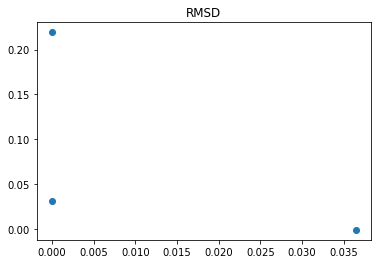

O=C(c1ccncc1)c1ccc(OCC[NH+]2CCCC2)cc1
tensor(0.1171)


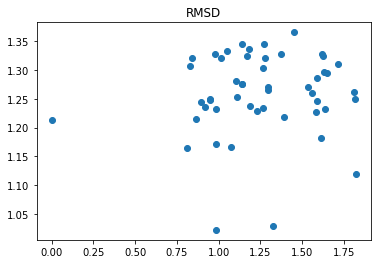

CC1(C)NC(=[NH2+])N(Cc2cccc(Cl)c2)C1=O
tensor(0.4557)


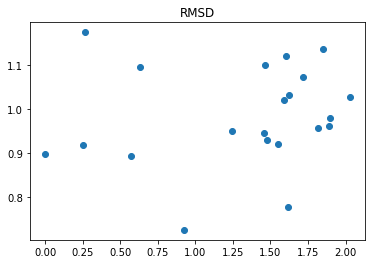

OC[C@H]1O[C@@H](NC(=S)/N=N/Cc2ccncc2)[C@H](O)[C@@H](O)[C@@H]1O
tensor(0.1511)


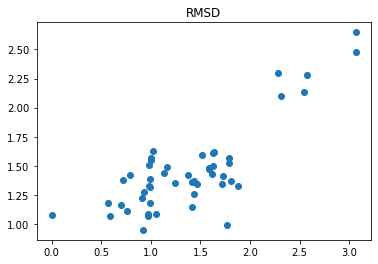

C[C@@]1(O)CCN2C(=O)CCc3cccc1c32
tensor(0.0950)


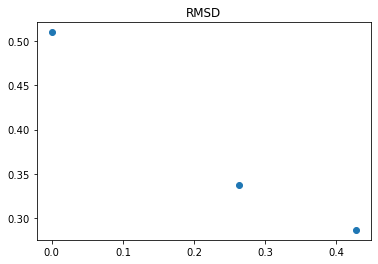

[NH3+][C@@H](CO)C(=O)[O-]
tensor(0.0424)


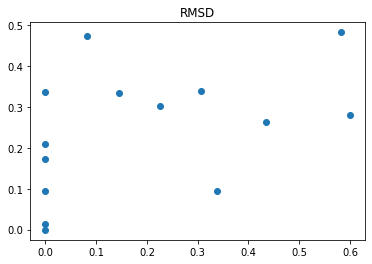

O=C([O-])c1sccc1S(=O)(=O)NC1CC1
tensor(0.4717)


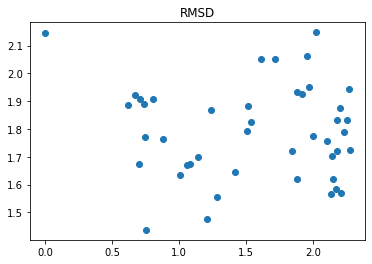

N#Cc1cccnc1N1CC[C@]2(c3ccc(F)cc3F)NC(=[NH2+])O[C@@H]2C1
tensor(0.2897)


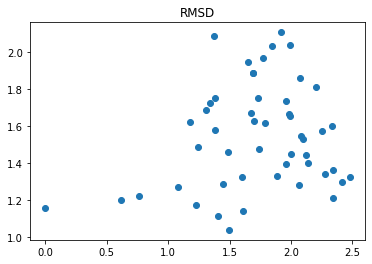

N#Cc1cccnc1N1CC[C@H]2OC(=[NH2+])N[C@@]2(c2ccc(F)cc2F)C1
tensor(0.6647)


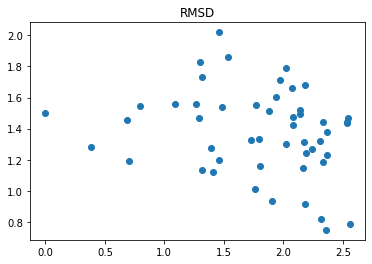

[NH2+]=C1NC(=O)/C(=C\c2ccc(O)cc2)S1
tensor(0.1997)


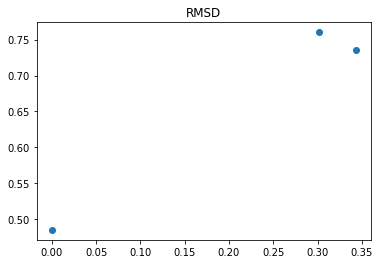

CC(=O)Nc1[nH]c(=O)c2nc(C)cnc2[nH+]1
tensor(1.1344)


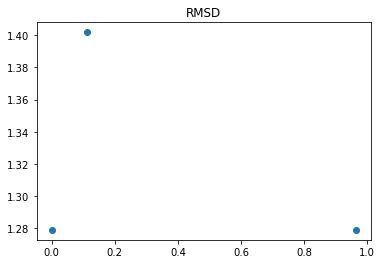

COc1ccc(CC[N@H+](C)CCC[C@@](C#N)(c2ccc(OC)c(OC)c2)C(C)C)cc1OC
tensor(1.7854)


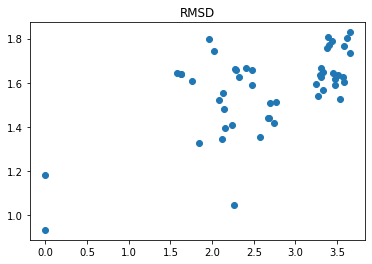

O=c1[nH]ccc2ccccc12
tensor(0.0067)


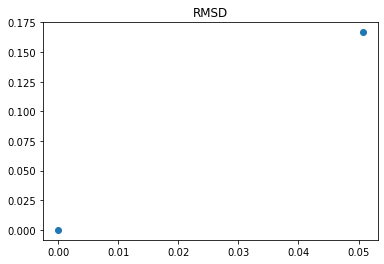

O=C1CNc2ccc(C(F)(F)F)cc2N1
tensor(0.1549)


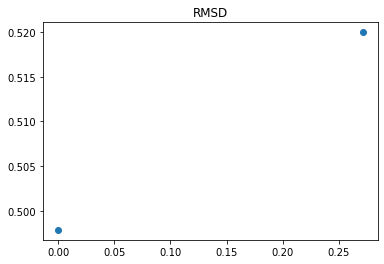

CC[C@H]1Nc2ccc(C(=O)[O-])cc2NC1=O
tensor(0.1828)


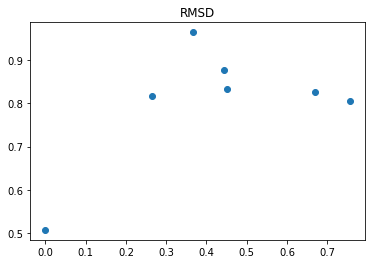

In [9]:
data_dict = group_data_by_smiles(test_dataset)
rmsds = []
pred_rmsds = []
rmsd_losses = []
relu = torch.nn.LeakyReLU()
mseloss = torch.nn.MSELoss()
schnet.eval()
for smiles, data_list in data_dict.items() :
    
    print(smiles)
    mol_rmsd = []
    mol_pred_rmsd = []
    loader = DataLoader(data_list, batch_size=32, shuffle=False)
    
    for batch in loader :
        batch = batch.to('cuda')
        preds = schnet(batch.x[:,56].long(), batch.pos, batch.batch)
        rmsd_pred = relu(preds[:, 0]) # to scale between 0 and +inf
        if batch.rmsd.max() > 50 :
            wrong_batch = batch
        mol_rmsd.extend(batch.rmsd.cpu().numpy())
        mol_pred_rmsd.extend(rmsd_pred.detach().cpu().numpy())
        
    rmsd_loss = mseloss(torch.tensor(mol_rmsd), torch.tensor(mol_pred_rmsd))
    rmsd_losses.append(rmsd_loss.item())
    print(rmsd_loss)

    rmsds.extend(mol_rmsd)
    pred_rmsds.extend(mol_pred_rmsd)
    
    plt.scatter(mol_rmsd, mol_pred_rmsd)
    plt.title('RMSD')
    plt.show()

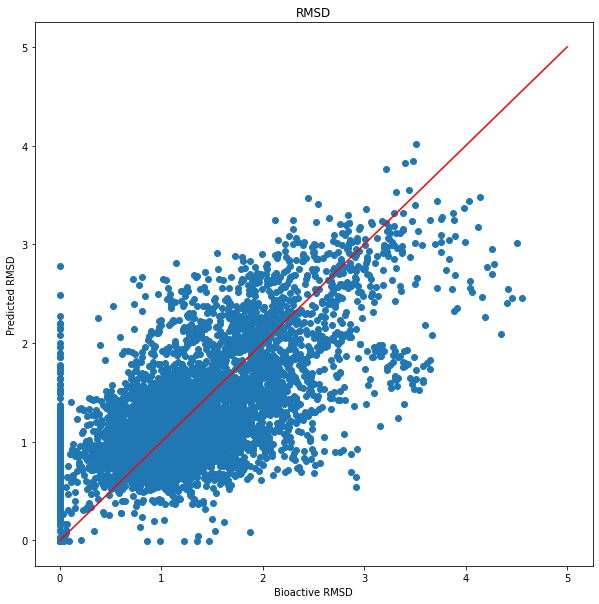

In [26]:
plt.figure(figsize=(10,10))
plt.scatter(rmsds, pred_rmsds)
plt.title('RMSD')
plt.xlabel('Bioactive RMSD')
plt.ylabel('Predicted RMSD')
plt.plot([0, 5], [0, 5], c='r')
plt.show()

<AxesSubplot:>

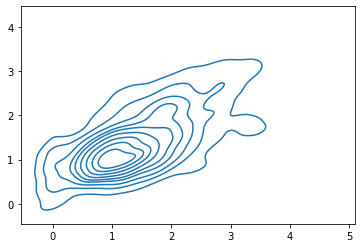

In [27]:
import seaborn as sns
sns.kdeplot(x=rmsds, y=pred_rmsds)

In [11]:
from sklearn.metrics import r2_score
r2_score(rmsds, pred_rmsds)

0.38299451724229505

In [12]:
schnet.eval()

test_losses = []
for batch in test_loader :
    loss = training_step(schnet, batch)
    test_losses.append(loss.item())

In [13]:
np.sum(test_losses) / len(test_loader)

0.34699261801030773

In [14]:
def get_max_sim_to_train_dataset(mol, train_fps) :
    test_fp = AllChem.GetMorganFingerprint(mol, 2)
    sims = []
    for train_fp in train_fps :
        dice_sim = DataStructs.DiceSimilarity(test_fp, train_fp)
        sims.append(dice_sim)
    max_sim = max(sims)
    return max_sim

In [15]:
from rdkit import DataStructs

In [16]:
data_dict = defaultdict(list)
for i, data in enumerate(test_dataset) :
    smiles = data.smiles
    data_dict[smiles].append(i)

all_ranks = []
accuracies = []
rmsd_losses = []
num_ha = []
max_sims = []
min_rmsds = []

train_smiles = set([data.smiles for data in train_dataset])
train_mols = [Chem.MolFromSmiles(smiles) for smiles in train_smiles]
train_fps = [AllChem.GetMorganFingerprint(mol, 2) for mol in train_mols]

leaky_relu = torch.nn.LeakyReLU()
mseloss = torch.nn.MSELoss()
for smiles, idxs in data_dict.items() :
    
    mol_ys = []
    mol_preds = []
    loader = DataLoader(test_dataset[idxs], batch_size=16)
    for batch in loader :
        batch = batch.to('cuda')
        preds = schnet(batch.x[:,56].long(), batch.pos, batch.batch)
        rmsd_preds = leaky_relu(preds[:, 0])
        
        mol_ys.extend(batch.rmsd.cpu().numpy().tolist())
        rmsd_preds = rmsd_preds.detach().cpu().numpy().squeeze().tolist()
        if type(rmsd_preds) == float :
            rmsd_preds = [rmsd_preds]
        mol_preds.extend(rmsd_preds)
        
    rmsd_loss = mseloss(torch.tensor(mol_ys), torch.tensor(mol_preds))
        
    mol_ys = np.array(mol_ys)
    mol_preds = np.array(mol_preds)
        
    is_bioactive = mol_ys < 0.1

    rank = mol_preds.argsort().argsort()
    bioactive_ranks = rank[is_bioactive]
    
    bioactive_ranks = bioactive_ranks.tolist()
    if len(bioactive_ranks) :
        accuracy = len(set(bioactive_ranks).intersection(set(range(len(bioactive_ranks))))) / len(bioactive_ranks)

        all_ranks.extend(bioactive_ranks)
        accuracies.append(accuracy)
        
        mol = Chem.MolFromSmiles(smiles)
        max_sim = get_max_sim_to_train_dataset(mol, train_fps)
        max_sims.append(max_sim)
        
        rmsd_losses.append(rmsd_loss.item())
        num_ha.append(mol.GetNumHeavyAtoms())
        
        generated_confs = mol_ys > 0.01
        generated_preds = mol_preds[generated_confs]
        min_rmsd = generated_preds.min()
        min_rmsds.append(min_rmsd)

In [17]:
(np.array(min_rmsds) < 1).sum()

114

In [18]:
(np.array(min_rmsds) > 1).sum()

42

In [19]:
np.mean(accuracies)

0.4968124823894055

In [20]:
np.mean(all_ranks)

6.460176991150442

{'whiskers': [<matplotlib.lines.Line2D at 0x7fc535097f50>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc5350b0d50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc5350a6b50>],
 'medians': [<matplotlib.lines.Line2D at 0x7fc53485a2d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fc53485ab50>],
 'means': []}

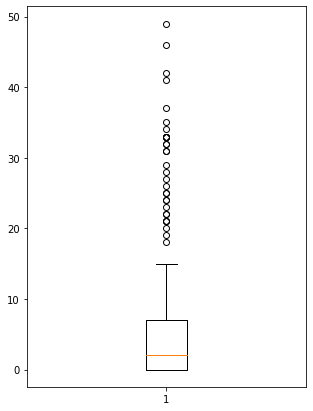

In [21]:
plt.figure(figsize=(5, 7))
plt.boxplot(all_ranks)

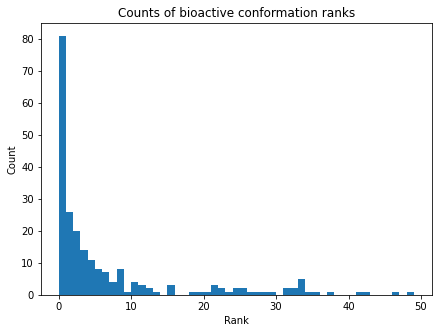

In [22]:
plt.figure(figsize=(7, 5))
plt.hist(all_ranks, bins=49)
plt.xlabel('Rank')
plt.ylabel('Count')
plt.title('Counts of bioactive conformation ranks')
plt.savefig('Histogram_ranks', dpi=300)

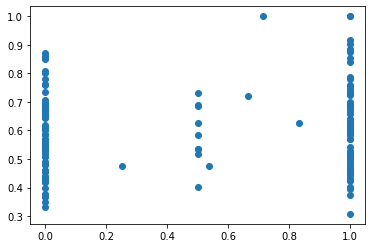

In [23]:
plt.scatter(accuracies, max_sims)

(0.0, 2.0)

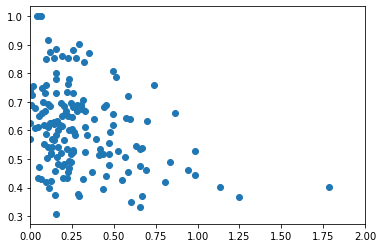

In [24]:
plt.scatter(rmsd_losses, max_sims)
plt.xlim(0, 2)

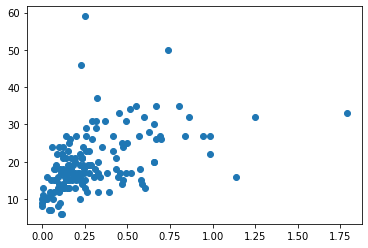

In [25]:
plt.scatter(rmsd_losses, num_ha)

# Molecule Overlap between Train, Val and Test sets

In [29]:
train_noh_smiles = set()
for data in train_dataset :
    smiles = Chem.MolToSmiles(Chem.RemoveHs(Chem.MolFromSmiles(data.smiles)), isomericSmiles=False)
    train_noh_smiles.update([smiles])

In [30]:
val_noh_smiles = set()
for data in val_dataset :
    smiles = Chem.MolToSmiles(Chem.RemoveHs(Chem.MolFromSmiles(data.smiles)), isomericSmiles=False)
    val_noh_smiles.update([smiles])

In [36]:
test_noh_smiles = set()
for data in test_dataset :
    smiles = Chem.MolToSmiles(Chem.RemoveHs(Chem.MolFromSmiles(data.smiles)), isomericSmiles=False)
    test_noh_smiles.update([smiles])

In [31]:
overlap = train_noh_smiles.intersection(val_noh_smiles)
len(overlap)

In [37]:
overlap = train_noh_smiles.intersection(test_noh_smiles)
len(overlap)

7

In [33]:
len(train_noh_smiles)

3149

In [34]:
len(val_noh_smiles)

859

In [45]:
all_ranks = []
accuracies = []

for smiles, idxs in data_dict.items() :
    mol_ys = []
    mol_preds = []
    loader = DataLoader(val_dataset[idxs], batch_size=16)
    for batch in loader :
        batch = batch.to('cuda')
        preds = schnet2(batch.x[:,56].long(), batch.pos, batch.batch)
        tfd_preds = preds[:, 1]
        
        mol_ys.extend(batch.tfd.cpu().numpy().tolist())
        tfd_preds = tfd_preds.detach().cpu().numpy().squeeze().tolist()
        if type(tfd_preds) == float :
            tfd_preds = [tfd_preds]
        mol_preds.extend(tfd_preds)
        
    mol_ys = np.array(mol_ys)
    mol_preds = np.array(mol_preds)
        
    is_bioactive = mol_ys < 0.1

    rank = mol_preds.argsort().argsort()
    bioactive_ranks = rank[is_bioactive]
    
    bioactive_ranks = bioactive_ranks.tolist()
    if len(bioactive_ranks) :
        accuracy = len(set(bioactive_ranks).intersection(set(range(len(bioactive_ranks))))) / len(bioactive_ranks)

        all_ranks.extend(bioactive_ranks)
        accuracies.append(accuracy)

In [46]:
np.mean(accuracies)

0.3690211587175861

In [47]:
np.mean(all_ranks)

19.745909528392684

{'whiskers': [<matplotlib.lines.Line2D at 0x7f9e7f8bc950>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9e7f8bf210>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9e7eb8c2d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9e7f8bfa50>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f9e7f8bfe50>],
 'means': []}

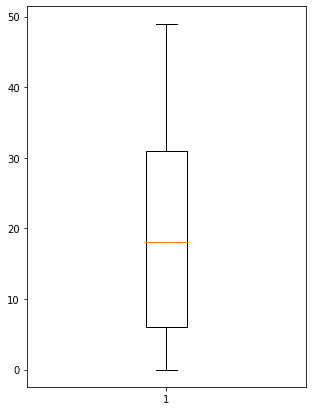

In [48]:
plt.figure(figsize=(5, 7))
plt.boxplot(all_ranks)

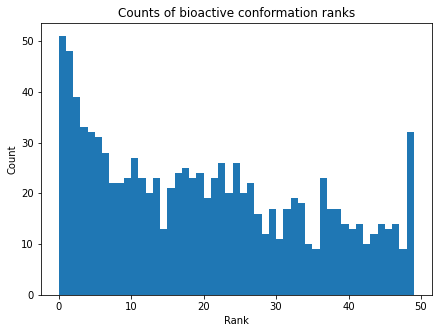

In [49]:
plt.figure(figsize=(7, 5))
plt.hist(all_ranks, bins=49)
plt.xlabel('Rank')
plt.ylabel('Count')
plt.title('Counts of bioactive conformation ranks')
plt.savefig('Histogram_ranks', dpi=300)

In [72]:
from sklearn.metrics import balanced_accuracy_score

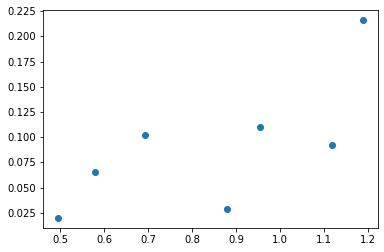

In [83]:
plt.scatter(mol_rmsds, mol_tfds)

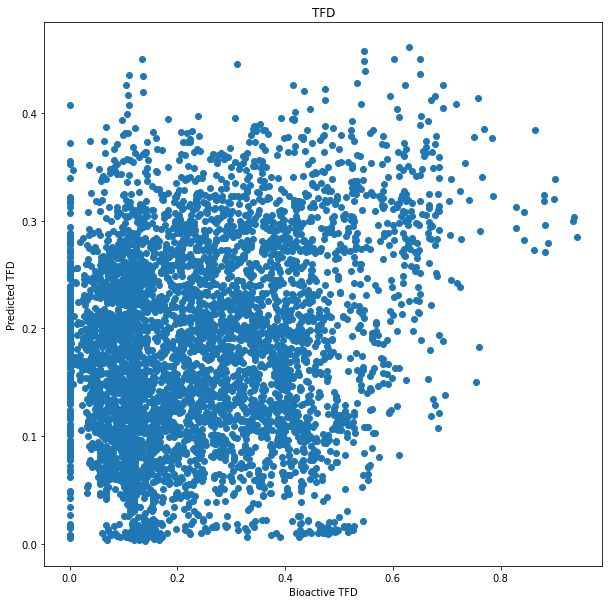

In [16]:
plt.figure(figsize=(10,10))
plt.scatter(tfds, pred_tfds)
plt.title('TFD')
plt.xlabel('Bioactive TFD')
plt.ylabel('Predicted TFD')
plt.show()

[H]N1C(=[N+]([H])[H])N([H])[C@@]2([H])C([H])([H])S[C@@]([H])(C([H])([H])C([H])([H])C([H])([H])C([H])([H])C(=O)[O-])[C@@]12[H]
tensor(0.1615, grad_fn=<MseLossBackward>)


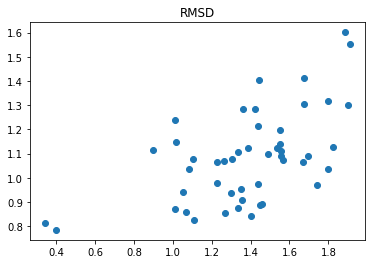

[H]Oc1c([H])c([H])c(C2=C(c3c([H])c([H])c(O[H])c([H])c3[H])[C@]3([H])O[C@@]2([H])[C@]([H])(C(=O)OC([H])([H])C([H])([H])[H])[C@]3([H])C(=O)OC([H])([H])C([H])([H])[H])c([H])c1[H]
tensor(0.5662, grad_fn=<MseLossBackward>)


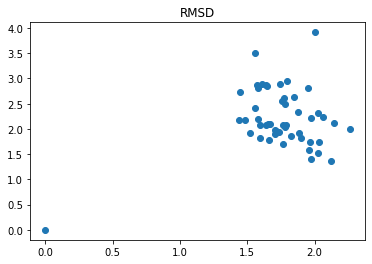

[H]c1nc([H])c([H])c(C([H])([H])N([H])c2c([H])c(-c3c([H])c([H])c([H])c([H])c3F)nc3c([H])c([H])nn23)c1[H]
tensor(0.2807, grad_fn=<MseLossBackward>)


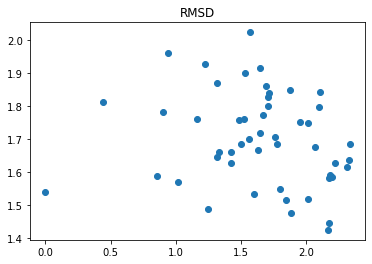

[H]c1c([H])c([H])c(C([H])([H])N([C@@]2([H])C([H])([H])[N+]([H])([H])C([H])([H])[C@]2([H])N(C([H])([H])c2c([H])c([H])c([H])c([H])c2[H])S(=O)(=O)c2c([H])c([H])c(N([H])[H])c([H])c2[H])S(=O)(=O)c2c([H])c([H])c(N([H])[H])c([H])c2[H])c([H])c1[H]
tensor(2.1677, grad_fn=<MseLossBackward>)


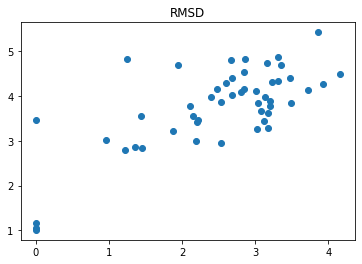

[H]OC([H])([H])[C@@]1([H])N([H])/C(=N\C([H])([H])C([H])([H])[N+]([H])([H])[H])[C@@]([H])(O[H])[C@@]([H])(O[H])[C@]1([H])O[H]
tensor(0.1977, grad_fn=<MseLossBackward>)


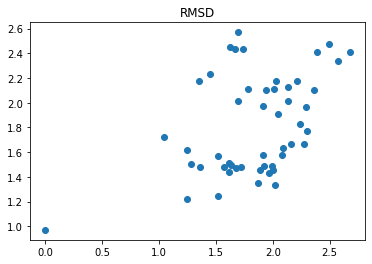

[H]c1c([H])c([H])c(C([H])([H])[N@@+]2([H])[C@@]3([H])C([H])([H])C([H])([H])[C@]2([H])C([H])([H])[C@]([H])(OC2([H])c4c([H])c([H])c([H])c([H])c4C([H])([H])C([H])([H])c4c([H])c([H])c([H])c([H])c42)C3([H])[H])c([H])c1[H]
tensor(0.2899, grad_fn=<MseLossBackward>)


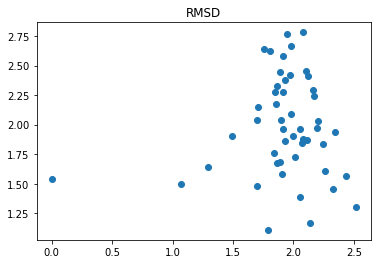

[H]c1nc([H])c(C(=O)C([H])([H])C([H])([H])C([H])([H])C([H])([H])[N+]([H])([H])[H])c([H])c1[H]
tensor(0.0697, grad_fn=<MseLossBackward>)


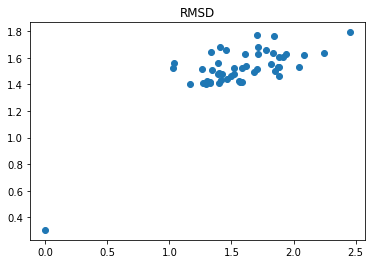

[H]C(=O)[C@@]1([H])N(C(=O)N([H])[C@@]2([H])C([H])([H])C([H])([H])C([H])([H])[N+]([H])([H])C([H])([H])C2([H])[H])C([H])([H])C([H])([H])[C@@]1([H])N([H])S(=O)(=O)[O-]
tensor(0.3381, grad_fn=<MseLossBackward>)


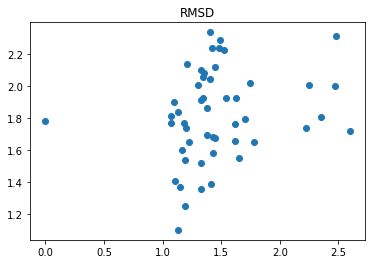

[H]c1nc2c(c([H])nn2[H])c(N2C([H])([H])C([H])([H])O[C@@]([H])(C([H])([H])[N+]([H])([H])[H])C2([H])[H])c1C(=O)OC([H])([H])C([H])([H])[H]
tensor(0.2666, grad_fn=<MseLossBackward>)


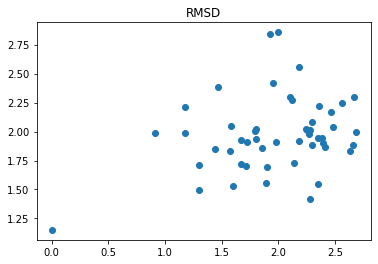

[H]c1oc(C(=O)N([H])[C@]([H])(C(=O)N2C([H])([H])c3c(c4c([H])c([H])c([H])c([H])c4n3[H])C([H])([H])[C@@]2([H])C(=O)[O-])C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H])c([H])c1[H]
tensor(1.2482, grad_fn=<MseLossBackward>)


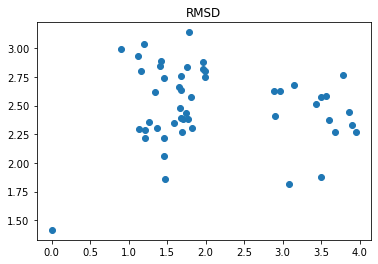

[H]c1c(N=C=S)c([H])c2c([H])c(C3=NC([H])([H])C([H])([H])N3[H])oc2c1[H]
tensor(0.3278, grad_fn=<MseLossBackward>)


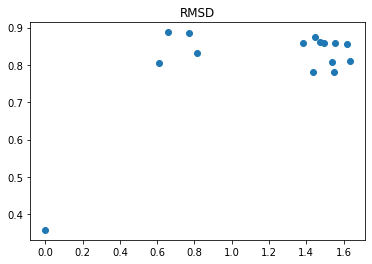

[H]c1c([H])c([N+](=O)[O-])c([H])c([H])c1C(=O)C([H])([H])C(=O)C(F)(F)F
tensor(0.0852, grad_fn=<MseLossBackward>)


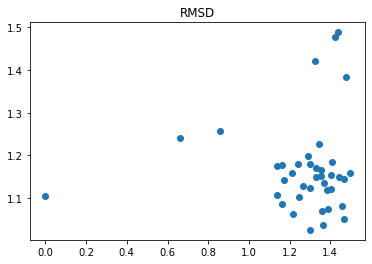

[H]Oc1c([H])c([H])c(Cl)c([H])c1Oc1c([H])c([H])c(Cl)c2c([H])c([H])c([H])nc12
tensor(0.3956, grad_fn=<MseLossBackward>)


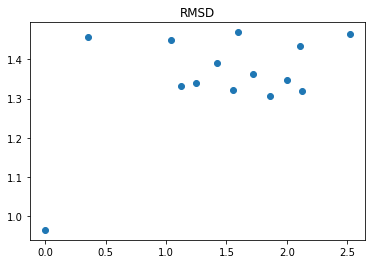

[H]OC([H])([H])[C@@]([H])(c1c([H])c([H])c([H])c([H])c1[H])[N+]([H])([H])C([H])([H])[C@@]1([H])N(C([H])([H])[H])C(=O)[C@]([H])(O[H])[C@]1([H])O[H]
tensor(0.5026, grad_fn=<MseLossBackward>)


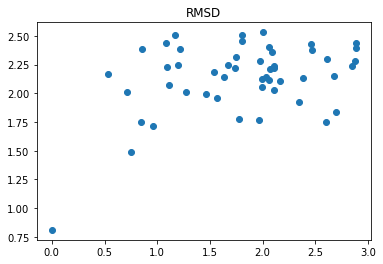

[H]Oc1c([H])c([H])c(Cl)c([H])c1N1C(=O)C([H])([H])S[C@@]1([H])c1c([H])c([H])c([H])c(Br)c1[H]
tensor(0.6374, grad_fn=<MseLossBackward>)


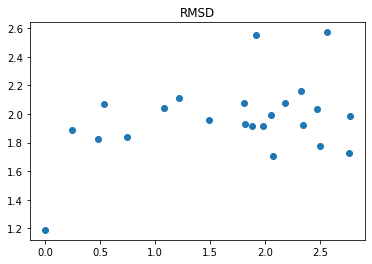

[H]O[C@]1(C(=O)OC([H])([H])[H])C([H])([H])[C@@]2([H])O[C@]1(C([H])([H])[H])n1c3c([H])c([H])c([H])c([H])c3c3c4c(c5c6c([H])c([H])c([H])c([H])c6n2c5c31)C(=O)N([H])C4([H])[H]
tensor(2.3099, grad_fn=<MseLossBackward>)


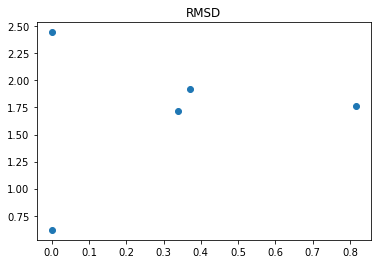

[H]c1c([H])c([H])c2c(c1[H])N([H])C(=O)[C@@]21C([H])([H])[C@]([H])(C(=O)O[C@]2([H])c3c([H])c(Br)c([H])c([H])c3S(=O)(=O)C([H])([H])C2([H])[H])[N+]([H])([H])C1([H])[H]
tensor(0.5375, grad_fn=<MseLossBackward>)


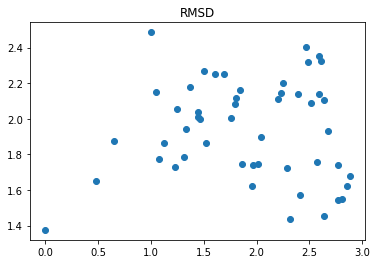

[H]c1nc(N2C([H])([H])C([H])([H])C3(C([H])([H])C2([H])[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[N+]3([H])[H])c2c(n1)nc([H])n2[H]
tensor(0.2719, grad_fn=<MseLossBackward>)


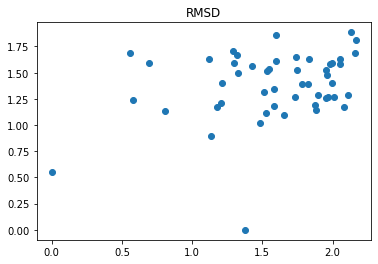

[H]c1nc2c(c([H])c(C([H])(C([H])([H])[H])C([H])([H])[H])n2[H])c(-c2c([H])c([H])c(S(=O)(=O)N([H])C3([H])C([H])([H])C([H])([H])S(=O)(=O)C([H])([H])C3([H])[H])c([H])c2[H])c1[H]
tensor(0.5263, grad_fn=<MseLossBackward>)


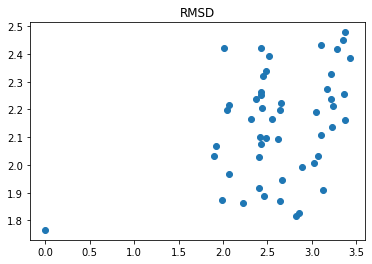

[H]c1nn([H])c([H])c1-c1c([H])c([H])c(C(=O)N([H])c2c([H])c([H])c([H])c([H])c2[H])c(OC([H])([H])C([H])([H])C([H])([H])[N+]([H])([H])[H])c1[H]
tensor(0.1950, grad_fn=<MseLossBackward>)


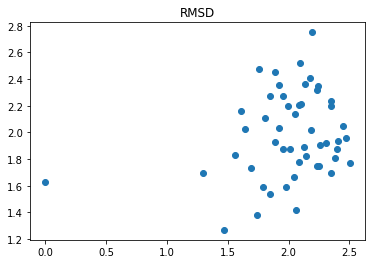

[H]c1c([H])c(S(=O)(=O)N2C([H])([H])C([H])([H])[N+]([H])(C([H])([H])[H])C([H])([H])C2([H])[H])c([H])c(-c2nc3c(c(=O)n2[H])C([H])([H])C([H])([H])C3([H])[H])c1OC([H])([H])C([H])([H])C([H])([H])[H]
tensor(0.8581, grad_fn=<MseLossBackward>)


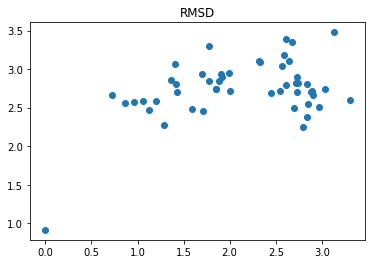

[H]c1c(Cl)c(N([H])C(=O)C([H])([H])[H])c(Cl)c([H])c1C([H])([H])N([H])C(N([H])C(=O)C([H])([H])n1c([H])c([H])c2c([H])c([H])c([H])c([H])c21)=[N+]([H])[H]
tensor(0.5987, grad_fn=<MseLossBackward>)


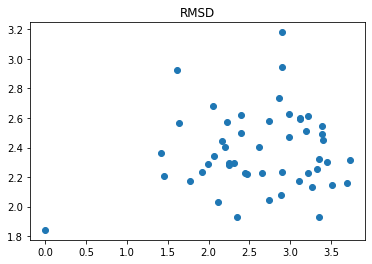

[H]/C1=C(/C([H])([H])[H])C(=O)N([H])c2c([H])c(OC([H])([H])[H])c([H])c(c2[H])C([H])([H])OC([H])([H])[C@]([H])(OC([H])([H])[H])[C@]([H])(OC([H])([H])[H])[C@@]([H])(C([H])([H])[H])/C([H])=C(\C([H])([H])[H])[C@]([H])(OC(=O)N([H])[H])[C@@]([H])(OC(=O)N([H])[H])C([H])([H])C1([H])[H]
tensor(0.5251, grad_fn=<MseLossBackward>)


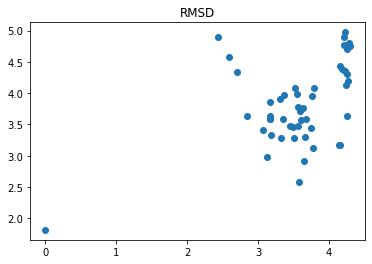

[H]c1c([H])c([H])c(C([H])([H])[C@]2([H])O[C@@]([H])(c3c([H])c([H])c(Br)c([H])c3[H])[C@@]([H])(c3c([H])c([H])c(Br)c([H])c3[H])N(C([H])([H])[H])C2=O)c([H])c1[H]
tensor(1.9150, grad_fn=<MseLossBackward>)


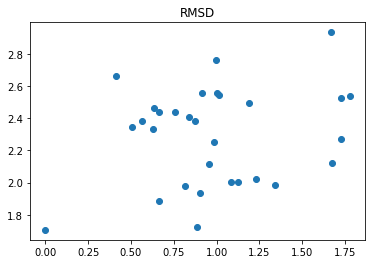

[H]c1c(Br)c2c(c([H])c1C([H])([H])[H])C(=O)C(=O)N2[H]
tensor(0.1009, grad_fn=<MseLossBackward>)


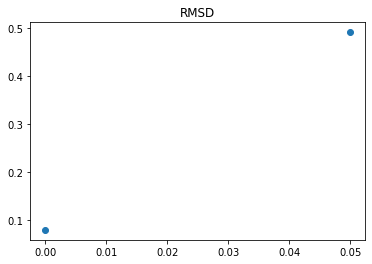

[H]OC([H])([H])[C@@]([H])(N([H])C(=O)C([H])([H])C([H])([H])c1nc2c([H])c([H])c([H])c([H])c2c(=O)n1[H])C([H])([H])c1c([H])c([H])c([H])c([H])c1[H]


KeyboardInterrupt: 

In [7]:
data_dict = group_data_by_smiles(test_dataset)
rmsds = []
tfds = []
pred_rmsds = []
pred_tfds = []
rmsd_losses = []
tfd_losses = []
relu = torch.nn.LeakyReLU()
mseloss = torch.nn.MSELoss()
schnet.eval()
for smiles, data_list in data_dict.items() :
    print(smiles)
    mol_rmsd = []
    mol_pred_rmsd = []
    loader = DataLoader(data_list, batch_size=32, shuffle=False)
    for batch in loader :
        batch = batch.to('cuda')
        preds = schnet(batch.x[:,56].long(), batch.pos, batch.batch)
    
        rmsd_pred = relu(preds[:, 0]) # to scale between 0 and +inf
        rmsd_loss = mseloss(rmsd_pred, batch.rmsd)
        rmsd_losses.append(rmsd_loss.item())
        print(rmsd_loss)

        rmsds.extend(batch.rmsd.cpu().numpy())
        pred_rmsds.extend(rmsd_pred.detach().cpu().numpy())
    
    plt.scatter(batch.rmsd.cpu().numpy(), rmsd_pred.detach().cpu().numpy())
    plt.title('RMSD')
    plt.show()
    
#     tfd_pred = torch.sigmoid(preds[:, 1]) # to scale betwenn 0 and 1
#     tfd_loss = mseloss(tfd_pred, batch.tfd)
#     tfd_losses.append(tfd_loss.item())
#     print(tfd_loss)
    
#     tfds.extend(batch.tfd.cpu().numpy())
#     pred_tfds.extend(tfd_pred.detach().cpu().numpy())
    
#     plt.scatter(batch.tfd.cpu().numpy(), tfd_pred.detach().cpu().numpy())
#     plt.title('TFD')
#     plt.show()

In [99]:
all_ranks = []
accuracies = []
bas = []

for smiles, idxs in data_dict.items() :
    mol_rmsds = []
    mol_tfds = []
    mol_rmsd_preds = []
    mol_tfd_preds = []
    loader = DataLoader(val_dataset[idxs], batch_size=16)
    for batch in loader :
        batch = batch.to('cuda')
        
        mol_rmsds.extend(batch.rmsd.cpu().numpy().tolist())
        mol_tfds.extend(batch.tfd.cpu().numpy().tolist())
        
        preds = schnet2(batch.x[:,56].long(), batch.pos, batch.batch)
        
        rmsd_preds = preds[:, 0]
        tfd_preds = preds[:, 1]
        
        rmsd_preds = rmsd_preds.detach().cpu().numpy().squeeze().tolist()
        if type(rmsd_preds) == float :
            rmsd_preds = [rmsd_preds]
        mol_rmsd_preds.extend(rmsd_preds)
        
        tfd_preds = tfd_preds.detach().cpu().numpy().squeeze().tolist()
        if type(tfd_preds) == float :
            tfd_preds = [tfd_preds]
        mol_tfd_preds.extend(tfd_preds)
        
    mol_rmsds = np.array(mol_rmsds)
    mol_tfds = np.array(mol_tfds)
    mol_rmsd_preds = np.array(mol_rmsd_preds)
    mol_tfd_preds = np.array(mol_tfd_preds)
        
    is_bioactive = (mol_rmsds < 1) #& (mol_tfds < 0.05)
    pred_bioactive = (mol_rmsd_preds < 1) #| (mol_tfd_preds < 0.05)
    if any(is_bioactive) :
        ba = balanced_accuracy_score(is_bioactive, pred_bioactive)
        bas.append(ba)

        rank = mol_rmsd_preds.argsort().argsort()
        bioactive_ranks = rank[is_bioactive]

        bioactive_ranks = bioactive_ranks.tolist()
        if len(bioactive_ranks) :
            accuracy = len(set(bioactive_ranks).intersection(set(range(len(bioactive_ranks))))) / len(bioactive_ranks)

            all_ranks.extend(bioactive_ranks)
            accuracies.append(accuracy)

/home/baillifb/anaconda3/envs/GeoMol/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1854: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/baillifb/anaconda3/envs/GeoMol/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1854: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


In [96]:
np.array(bas).mean()

0.6029266190134513

In [70]:
pred_bioactive = (mol_rmsd_preds < 0.1) | (mol_tfd_preds < 0.1)

In [54]:
is_bioactive

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False])

In [100]:
np.mean(accuracies)

0.4951161347576106

In [101]:
np.mean(all_ranks)

14.792431192660551

{'whiskers': [<matplotlib.lines.Line2D at 0x7f9e7ff10510>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9e47c44a10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9e47b31890>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9e47b106d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f9e47b10950>],
 'means': []}

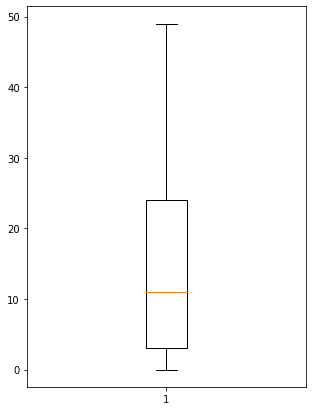

In [102]:
plt.figure(figsize=(5, 7))
plt.boxplot(all_ranks)

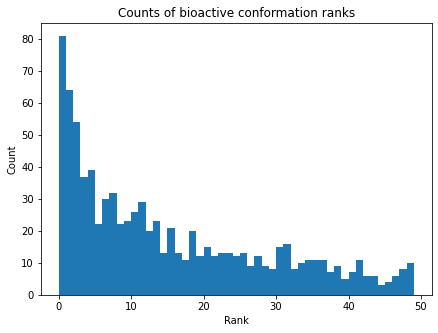

In [103]:
plt.figure(figsize=(7, 5))
plt.hist(all_ranks, bins=49)
plt.xlabel('Rank')
plt.ylabel('Count')
plt.title('Counts of bioactive conformation ranks')
plt.savefig('Histogram_ranks', dpi=300)

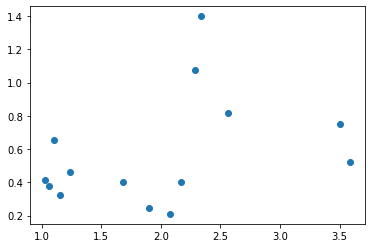

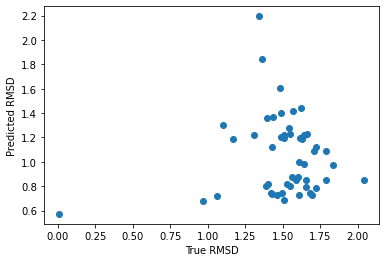

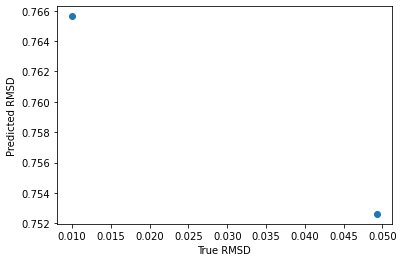

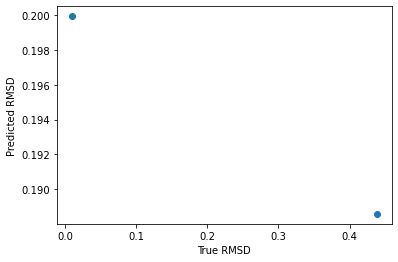

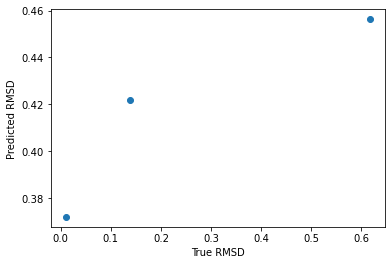

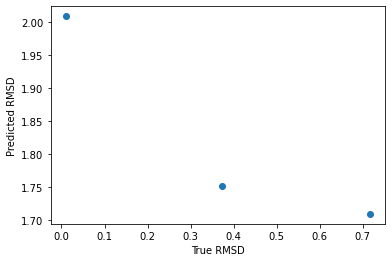

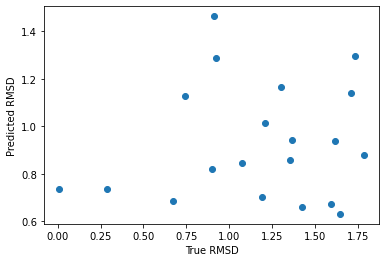

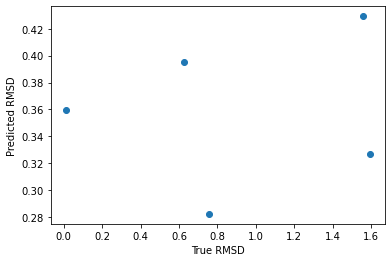

KeyboardInterrupt: 

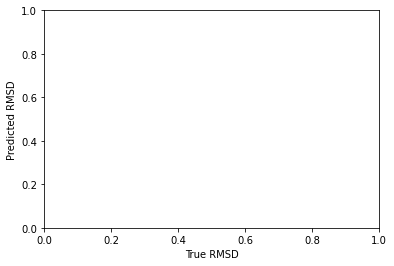

In [40]:
import time
all_ys = []
all_preds = []
mols = []
for smiles, idxs in data_dict.items() :
    mol_ys = []
    mol_preds = []
    loader = DataLoader(val_dataset[idxs], batch_size=16)
    for batch in loader :
        batch = batch.to('cuda')
        mol = Chem.MolFromSmiles(batch.smiles[0])
        mols.append(mol)
        preds = schnet2(batch.x[:,56].long(), batch.pos, batch.batch)
        mol_ys.extend(batch.rmsd.cpu().numpy().tolist())
        mol_preds.extend(preds.exp().detach().cpu().numpy().tolist())
    plt.scatter(mol_ys, mol_preds)
    plt.show()
    plt.xlabel('True RMSD')
    plt.ylabel('Predicted RMSD')
    #is_bioactive = int(batch.y.detach().cpu().numpy() == 0.01)
    all_ys.append(mol_ys)
    all_preds.append(mol_preds)
    time.sleep(1)

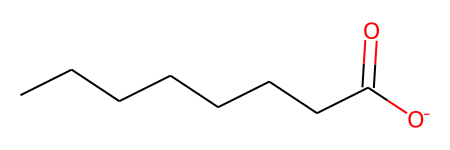

In [41]:
mols[1]

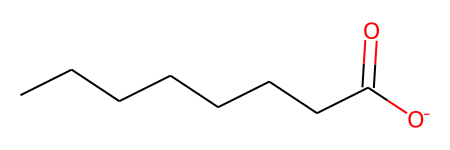

In [25]:
mols[2]

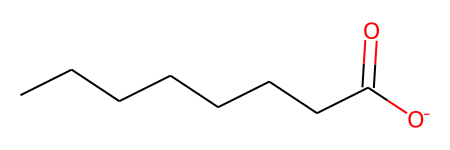

In [26]:
mols[3]

{'whiskers': [<matplotlib.lines.Line2D at 0x7f2560220510>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2560220d90>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f2560220150>],
 'medians': [<matplotlib.lines.Line2D at 0x7f2560218690>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f2560218ad0>],
 'means': []}

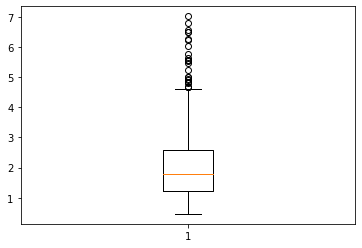

In [42]:
plt.boxplot(val_losses)

In [43]:
bioactive_rmsds = batch.rmsd.detach().cpu()

In [44]:
pred_rmsds = preds.exp().detach().cpu()

In [45]:
pred_rmsds

tensor([[0.3597],
        [0.3270],
        [0.4292],
        [0.2825],
        [0.3955]])

In [46]:
mols = [Chem.MolFromSmiles(s) for s in batch.smiles]
n_heavy_atoms = [mol.GetNumHeavyAtoms() for mol in mols]

In [47]:
squared_errors = torch.square(preds - batch.rmsd.log().unsqueeze(1)).detach().cpu()

In [48]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Number of heavy atoms')

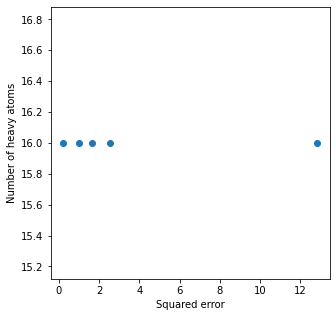

In [49]:
plt.figure(figsize=(5,5))
plt.scatter(squared_errors, n_heavy_atoms)
#plt.xlim(0, 7)
#plt.ylim(0, 5)
#plt.plot([0,5], [0,5])
plt.xlabel('Squared error')
plt.ylabel('Number of heavy atoms')

Text(0, 0.5, 'Number of heavy atoms')

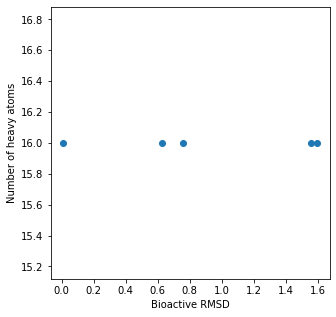

In [50]:
plt.figure(figsize=(5,5))
plt.scatter(bioactive_rmsds, n_heavy_atoms)
#plt.xlim(0, 7)
#plt.ylim(0, 5)
#plt.plot([0,5], [0,5])
plt.xlabel('Bioactive RMSD')
plt.ylabel('Number of heavy atoms')

Text(0, 0.5, 'Number of heavy atoms')

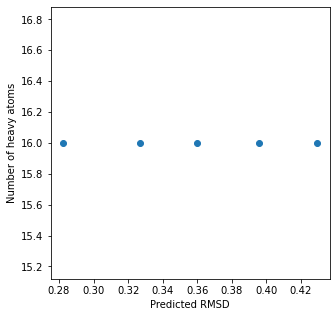

In [51]:
plt.figure(figsize=(5,5))
plt.scatter(pred_rmsds, n_heavy_atoms)
#plt.xlim(0, 7)
#plt.ylim(0, 5)
#plt.plot([0,5], [0,5])
plt.xlabel('Predicted RMSD')
plt.ylabel('Number of heavy atoms')

Text(0, 0.5, 'Predicted RMSD')

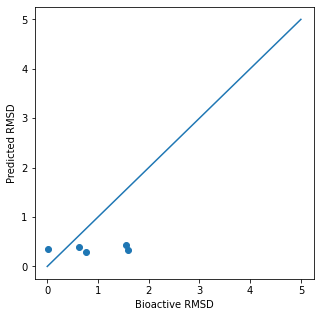

In [52]:
plt.figure(figsize=(5,5))
plt.scatter(bioactive_rmsds, pred_rmsds)
#plt.xlim(0, 5)
#plt.ylim(0, 5)
plt.plot([0,5], [0,5])
plt.xlabel('Bioactive RMSD')
plt.ylabel('Predicted RMSD')

In [28]:
preds

tensor([[5.5809],
        [5.8469]], device='cuda:0', grad_fn=<ScatterAddBackward>)

In [29]:
batch.y.log()

tensor([1.5215, 0.8020], device='cuda:0')

In [20]:
len(dataset)

236668

In [21]:
smiles = []
for data in dataset :
    if data.y == 0.01 :
        smiles.append(data.smiles)

In [22]:
from collections import Counter
c = Counter(smiles)

In [23]:
c.most_common()[0]

('[H]O[C@]([H])(C([H])([H])N(C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H])S(=O)(=O)c1c([H])c([H])c(N([H])[H])c([H])c1[H])[C@@]([H])(N([H])C(=O)O[C@@]1([H])C([H])([H])O[C@@]2([H])OC([H])([H])C([H])([H])[C@]21[H])C([H])([H])c1c([H])c([H])c([H])c([H])c1[H]',
 35)

In [24]:
most_common_smiles = c.most_common()[0][0]

In [25]:
# for smiles, conf_ensemble in tqdm(conf_ensemble_library.get_unique_molecules()) :
#     mol = conf_ensemble.mol
#     data_list = dataset.featurize_mol(mol)

In [26]:
data_ensemble = []
for data in dataset :
    if data.smiles == most_common_smiles :
        data_ensemble.append(data)

In [50]:
most_common_mol = conf_ensemble_library.get_conf_ensemble(most_common_smiles).mol

In [74]:
from rdkit.Chem.TorsionFingerprints import GetTFDMatrix, GetTFDBetweenConformers
from scipy.spatial.distance import squareform

In [51]:
rdkit_decoys = copy.deepcopy(most_common_mol)
cids = EmbedMultipleConfs(rdkit_decoys, 15, clearConfs=False)

In [52]:
[cid for cid in cids]

[35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]

In [53]:
rdkit_decoys.GetNumConformers()

50

In [54]:
tfd_matrix = squareform(GetTFDMatrix(rdkit_decoys))

In [47]:
Batch.from_data_list(data_ensemble).y

tensor([0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 4.2425,
        3.2086, 4.0902, 2.7070, 2.7178, 2.4065, 3.6938, 4.5432, 3.4962, 3.8905,
        3.8948, 4.0457, 3.4856, 3.0563, 3.2820])

In [67]:
tfd_matrix[0]

array([0.        , 0.02498095, 0.03412539, 0.02453632, 0.01856428,
       0.01628983, 0.02011488, 0.02388207, 0.02098394, 0.03696151,
       0.01735393, 0.02660693, 0.02349047, 0.01685428, 0.01591624,
       0.0298694 , 0.03024564, 0.01190867, 0.01707003, 0.01479341,
       0.0242654 , 0.01394391, 0.02019689, 0.01553145, 0.03130011,
       0.0143179 , 0.01620005, 0.02397508, 0.01902534, 0.05747179,
       0.03588157, 0.0303823 , 0.03967478, 0.04638873, 0.03912702,
       0.02831882, 0.04062053, 0.04768421, 0.03072303, 0.02437665,
       0.03251602, 0.04424735, 0.035359  , 0.02606463, 0.0364481 ,
       0.02347327, 0.0278658 , 0.02191388, 0.02613846, 0.01725462])

In [79]:
GetTFDBetweenConformers(rdkit_decoys, [0, 1], [0, 1])

[0.0, 0.024980946486236926, 0.024980946486236926, 0.0]

In [71]:
import numpy as np
from rdkit.Chem.rdMolAlign import GetBestRMS
rmsd_matrix = np.zeros((50, 50))
for conf_id1 in range(rdkit_decoys.GetNumConformers()) :
    for conf_id2 in range(rdkit_decoys.GetNumConformers()) :
        rmsd_matrix[conf_id1, conf_id2] = GetBestRMS(rdkit_decoys, rdkit_decoys, conf_id1, conf_id2, maxMatches=1000)

In [82]:
tfd_matrix = np.zeros((50, 50))
for conf_id1 in range(rdkit_decoys.GetNumConformers()) :
    for conf_id2 in range(rdkit_decoys.GetNumConformers()) :
        tfd_matrix[conf_id1, conf_id2] = GetTFDBetweenConformers(rdkit_decoys, [conf_id1], [conf_id2])[0]

In [83]:
tfd_matrix[0]

array([0.        , 0.02498095, 0.03412539, 0.01856428, 0.02388207,
       0.02660693, 0.03024564, 0.02019689, 0.05747179, 0.04768421,
       0.0278658 , 0.02803997, 0.03180698, 0.02689749, 0.02191215,
       0.01181887, 0.02017549, 0.05758138, 0.0284876 , 0.0236356 ,
       0.02444162, 0.1566667 , 0.02505116, 0.02786319, 0.01954324,
       0.02518331, 0.02680734, 0.02447116, 0.02149904, 0.01457815,
       0.02621564, 0.02278008, 0.02388158, 0.01983683, 0.01990052,
       0.40712306, 0.31065883, 0.36752045, 0.3425487 , 0.42697985,
       0.2924398 , 0.28071864, 0.29190729, 0.3841577 , 0.42422707,
       0.42557737, 0.25958493, 0.33727532, 0.39501014, 0.43249754])

In [80]:
rmsd_matrix[0]

array([0.        , 0.18506186, 0.16493749, 0.18781775, 0.26000489,
       0.42312892, 0.12980779, 0.12635767, 0.28876139, 0.27362755,
       0.20830762, 0.18329113, 1.27045034, 0.3173347 , 1.22336932,
       1.20868652, 1.2679377 , 1.68842703, 0.27636235, 0.25763946,
       0.12760645, 1.80087796, 0.21992653, 0.24781657, 0.27820717,
       0.54659634, 1.87396514, 0.28742004, 1.16367952, 1.19084149,
       1.5204243 , 1.70832136, 1.58784753, 1.61312932, 1.70560255,
       3.12011294, 3.2236527 , 2.9275899 , 2.89751939, 3.58985931,
       3.57527858, 3.39081861, 3.22633347, 3.12820171, 4.39621726,
       4.31319222, 4.59278367, 3.61257114, 3.71044695, 3.09929273])

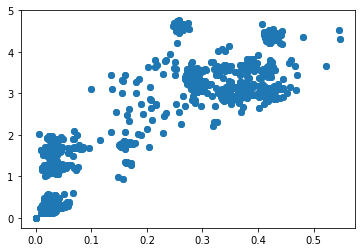

In [84]:
plt.scatter(tfd_matrix, rmsd_matrix)

In [65]:
import py3Dmol
from ipywidgets import interact,fixed,IntSlider
import ipywidgets
def MolTo3DView(mol, conf_id=0, size=(500, 500), style="stick", surface=False, opacity=0.5):
    """Draw molecule in 3D
    
    Args:
    ----
        mol: rdMol, molecule to show
        size: tuple(int, int), canvas size
        style: str, type of drawing molecule
               style can be 'line', 'stick', 'sphere', 'carton'
        surface, bool, display SAS
        opacity, float, opacity of surface, range 0.0-1.0
    Return:
    ----
        viewer: py3Dmol.view, a class for constructing embedded 3Dmol.js views in ipython notebooks.
    """
    assert style in ('line', 'stick', 'sphere', 'carton')
    mblock = Chem.MolToMolBlock(mol=mol, includeStereo=True, confId=conf_id)
    viewer = py3Dmol.view(width=size[0], height=size[1])
    viewer.addModel(mblock, 'mol')
    viewer.setStyle({style:{}})
    if surface:
        viewer.addSurface(py3Dmol.SAS, {'opacity': opacity})
    viewer.zoomTo()
    return viewer

In [66]:
def conf_viewer(idx):
    return MolTo3DView(rdkit_decoys, conf_id=idx).show()

interact(conf_viewer, idx=ipywidgets.IntSlider(min=0,max=49, step=1))

interactive(children=(IntSlider(value=0, description='idx', max=49), Output()), _dom_classes=('widget-interact…

<function __main__.conf_viewer(idx)>

In [100]:
len(data_ensemble)

50

In [31]:
batch = Batch.from_data_list(data_ensemble)

In [38]:
loader = DataLoader(data_ensemble, batch_size=25)

In [39]:
for batch in loader :
    batch = batch.to('cuda')
    preds = schnet2(batch.x[:,56].long(), batch.pos, batch.batch)
    print(mseloss(preds, batch.y.log().unsqueeze(1)).item())

20.502635955810547
9.539355278015137


In [45]:
preds.exp()

tensor([[1.2233],
        [2.1853],
        [1.5782],
        [1.2550],
        [1.2859],
        [1.1182],
        [1.0128],
        [1.1551],
        [1.1492],
        [1.2264],
        [5.7003],
        [3.0670],
        [6.3158],
        [4.0109],
        [3.5877],
        [4.6742],
        [3.8382],
        [5.1120],
        [4.0644],
        [2.8222],
        [4.2753],
        [2.7628],
        [5.8492],
        [4.0123],
        [6.4197]], device='cuda:0', grad_fn=<ExpBackward>)

In [46]:
batch.y

tensor([0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 4.2425, 3.2086, 4.0902, 2.7070, 2.7178, 2.4065, 3.6938, 4.5432,
        3.4962, 3.8905, 3.8948, 4.0457, 3.4856, 3.0563, 3.2820],
       device='cuda:0')

In [34]:
preds = schnet2(batch.x[:,56].long(), batch.pos, batch.batch)

RuntimeError: Input, output and indices must be on the current device

In [15]:
for conf in conf_ensemble_library.get_conf_ensemble(most_common_smiles).mol.GetConformers() :
    rdkit_decoys.AddConformer(conf, assignId=True)

In [16]:
data_list = dataset.featurize_mol(rdkit_decoys)
#y = torch.tensor([int('PDB_ID' in conf.GetPropsAsDict()) for conf in rdkit_decoys.GetConformers()], requires_grad=False)

#batch = Batch.from_data_list(data_list)
#batch.y = y.float()

In [17]:
#batch = batch.to('cuda')

In [50]:
from rdkit.Chem.rdMolAlign import GetBestRMS
import numpy as np

In [89]:
# to optimize
rmsd_to_bioactive = []
confs = rdkit_decoys.GetConformers()
rdkit_confs_id = []
bioactive_confs_id = []
for conf in confs :
    if 'PDB_ID' in conf.GetPropsAsDict() :
        bioactive_confs_id.append(conf.GetId())
    else :
        rdkit_confs_id.append(conf.GetId())
for conf_id in range(rdkit_decoys.GetNumConformers()) :
    rmsds = []
    if conf_id in rdkit_confs_id :
        for bioactive_conf_id in bioactive_confs_id :
            rmsds.append(GetBestRMS(rdkit_decoys, rdkit_decoys, conf_id, bioactive_conf_id, maxMatches=1000))
        rmsd_to_bioactive.append(min(rmsds))
    else :
        rmsd_to_bioactive.append(0)

In [90]:
y = torch.tensor(rmsd_to_bioactive, requires_grad=False)

In [93]:
for i, data in enumerate(data_list) :
    data.y = y[i]

In [95]:
loader = DataLoader(data_list, batch_size=16, shuffle=True)

In [96]:
for batch in loader :
    
    batch = batch.to('cuda')
    optimizer.zero_grad()

    preds = schnet(batch.x[:,56].long(), batch.pos, batch.batch)

In [16]:
batch.y.log().unsqueeze(1)

tensor([[ 0.9736],
        [ 0.4974],
        [-1.4957],
        [-1.0160],
        [-2.9565],
        [-0.8946],
        [ 1.3059],
        [ 0.1680],
        [ 0.9619],
        [-0.6091],
        [ 0.0148],
        [-1.9418],
        [ 0.7503],
        [ 0.4143],
        [ 0.4440],
        [-0.0153]], device='cuda:0')

In [29]:
schnet = SchNet().to('cuda')
mseloss = torch.nn.MSELoss()
optimizer = optim.Adam(schnet.parameters(), lr=0.000001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    
for batch in train_loader :

    optimizer.zero_grad()

    batch = batch.to('cuda')

    preds = schnet(batch.x[:,56].long(), batch.pos, batch.batch)

    loss = mseloss(preds, batch.y.log().unsqueeze(1))
    loss.backward()

    optimizer.step()

In [30]:
batch.y.log()

tensor([ 1.2071,  0.0471,  0.4974,  1.2825, -1.2034, -1.6983,  0.7586,  0.1490,
         0.1498,    -inf, -1.3439, -1.2998, -0.9966, -1.1205, -1.3509, -2.1767],
       device='cuda:0')

In [25]:
preds

tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan]], device='cuda:0', grad_fn=<ScatterAddBackward>)

In [10]:
preds

tensor([[ 2.1047],
        [ 2.1348],
        [ 1.5311],
        [ 2.6508],
        [ 0.8530],
        [ 3.4791],
        [ 2.1142],
        [ 0.0857],
        [ 3.0586],
        [ 5.3945],
        [ 0.4973],
        [ 1.6024],
        [ 0.7060],
        [-0.7919],
        [ 0.9858],
        [ 1.5892]], device='cuda:0', grad_fn=<ScatterAddBackward>)

In [11]:
batch.y

tensor([1.9710, 2.4865, 0.3691, 2.3161, 1.0153, 3.5619, 1.5852, 1.1187, 1.9109,
        2.0701, 0.3614, 0.3325, 0.2241, 0.0502, 0.2848, 2.0894],
       device='cuda:0')

In [39]:
# Training model on energy for ethane conformations (based on a single torsion)

ethane = Chem.MolFromSmiles('CC')
ethane = Chem.AddHs(ethane)
EmbedMultipleConfs(ethane, 50)

ethane_data = dataset.featurize_mol(ethane)

mmff_energies = []
mmff_props = MMFFGetMoleculeProperties(ethane)
for i in range(50) :
    mmff_ethane = MMFFGetMoleculeForceField(ethane, mmff_props, confId=i)
    mmff_energies.append(mmff_ethane.CalcEnergy())
y = torch.tensor(mmff_energies, requires_grad=False)

batch = Batch.from_data_list(ethane_data)
batch.y = y

schnet = SchNet()
mseloss = torch.nn.MSELoss()
optimizer = optim.SGD(schnet.parameters(), lr=0.0001, momentum=0.9)

for epoch in tqdm(range(1000)):  # loop over the dataset multiple times

    optimizer.zero_grad()
    
    preds = schnet(batch.x[:,56].long(), batch.pos, batch.batch)
    
    loss = mseloss(preds, batch.y.unsqueeze(1))
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0 :
        print(f'Loss at epoch {epoch} : {loss}')

print('Finished Training')

  0%|          | 4/1000 [00:00<00:31, 31.29it/s]

Loss at epoch 0 : 0.9281471371650696


 10%|█         | 104/1000 [00:03<00:26, 33.23it/s]

Loss at epoch 100 : 0.1309066116809845


 20%|██        | 204/1000 [00:06<00:23, 33.49it/s]

Loss at epoch 200 : 0.11741373687982559


 30%|███       | 304/1000 [00:09<00:21, 32.05it/s]

Loss at epoch 300 : 0.10905681550502777


 40%|████      | 404/1000 [00:12<00:17, 33.59it/s]

Loss at epoch 400 : 0.10324281454086304


 50%|█████     | 504/1000 [00:15<00:15, 32.51it/s]

Loss at epoch 500 : 0.09887970983982086


 60%|██████    | 604/1000 [00:18<00:12, 31.96it/s]

Loss at epoch 600 : 0.09545755386352539


 71%|███████   | 706/1000 [00:21<00:10, 28.94it/s]

Loss at epoch 700 : 0.09270357340574265


 80%|████████  | 805/1000 [00:24<00:05, 33.27it/s]

Loss at epoch 800 : 0.09044767171144485


 90%|█████████ | 904/1000 [00:28<00:03, 29.33it/s]

Loss at epoch 900 : 0.08857133984565735


100%|██████████| 1000/1000 [00:31<00:00, 32.04it/s]

Finished Training


In [40]:
preds

tensor([[-2.3831],
        [-1.9917],
        [ 0.3335],
        [ 0.2064],
        [-1.1179],
        [-2.0901],
        [ 0.3346],
        [-1.9903],
        [-1.2269],
        [ 0.3837],
        [ 0.4912],
        [ 0.1590],
        [-0.0482],
        [-1.4688],
        [-2.3531],
        [ 0.3832],
        [-2.3209],
        [-0.3396],
        [-0.5675],
        [-1.6591],
        [-1.9341],
        [-2.0192],
        [-1.5823],
        [-1.9956],
        [-2.0675],
        [-1.5545],
        [-2.0488],
        [-2.2495],
        [-1.9580],
        [-2.1588],
        [-2.1751],
        [-0.3586],
        [-2.1320],
        [ 0.3774],
        [-1.3506],
        [ 0.4022],
        [-2.1126],
        [-1.4260],
        [-0.0340],
        [-0.2537],
        [-1.6046],
        [-1.0991],
        [-0.3191],
        [-0.7812],
        [-1.8599],
        [-1.3839],
        [-0.2052],
        [-1.8140],
        [-0.4449],
        [-1.8697]], grad_fn=<ScatterAddBackward>)

In [37]:
batch.y

tensor([-2.2988, -1.7409,  0.6701,  0.2891, -1.0283, -2.0713,  0.3660, -1.4809,
        -1.1378,  0.5946, -0.1097, -0.4245,  0.3206, -1.6801, -2.5620,  0.4036,
        -2.6961, -0.3537, -0.8001, -1.4473, -1.5599, -1.9381, -1.7167, -1.6778,
        -1.9246, -1.2828, -1.8108, -2.5876, -1.8726, -2.2210, -2.6131, -0.4736,
        -2.6236,  0.1864, -1.5772,  1.3729, -2.0485, -1.6483,  0.1577, -0.5730,
        -1.6974, -0.9654, -0.4518, -0.9505, -2.0824, -0.9357, -0.2079, -1.8515,
        -0.7863, -1.7279])

In [13]:
egnn = EGNN(in_node_nf=80, in_edge_nf=8, hidden_nf=50)

In [41]:
mseloss = torch.nn.MSELoss()
optimizer = optim.SGD(egnn.parameters(), lr=0.001, momentum=0.9)

for epoch in tqdm(range(100)):  # loop over the dataset multiple times

    optimizer.zero_grad()
    
    preds = egnn(batch=batch)
    
    loss = mseloss(preds, batch.y.unsqueeze(1))
    loss.backward()
    optimizer.step()
    
    print(loss)

print('Finished Training')

NameError: name 'egnn' is not defined

In [18]:
import py3Dmol
def MolTo3DView(mol, conf_id=0, size=(300, 300), style="stick", surface=False, opacity=0.5):
    """Draw molecule in 3D
    
    Args:
    ----
        mol: rdMol, molecule to show
        size: tuple(int, int), canvas size
        style: str, type of drawing molecule
               style can be 'line', 'stick', 'sphere', 'carton'
        surface, bool, display SAS
        opacity, float, opacity of surface, range 0.0-1.0
    Return:
    ----
        viewer: py3Dmol.view, a class for constructing embedded 3Dmol.js views in ipython notebooks.
    """
    assert style in ('line', 'stick', 'sphere', 'carton')
    mblock = Chem.MolToMolBlock(mol=mol, includeStereo=True, confId=conf_id)
    viewer = py3Dmol.view(width=size[0], height=size[1])
    viewer.addModel(mblock, 'mol')
    viewer.setStyle({style:{}})
    if surface:
        viewer.addSurface(py3Dmol.SAS, {'opacity': opacity})
    viewer.zoomTo()
    return viewer

MolTo3DView(ethane, 2)

In [23]:
MolTo3DView(ethane, 2)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [20]:
for data in ethane_data :
    print(egnn(h0=data.x, x=data.pos, edges=data.edge_index, edge_attr=data.edge_attr, node_mask=torch.ones(data.x.shape[0]), edge_mask=None, n_nodes=len(data.x)))

tensor([-0.1381], grad_fn=<SqueezeBackward1>)
tensor([-0.1381], grad_fn=<SqueezeBackward1>)
tensor([-0.1382], grad_fn=<SqueezeBackward1>)


In [15]:
for data in data_ensemble :
    print(egnn(h0=data.x, x=data.pos, edges=data.edge_index, edge_attr=data.edge_attr, node_mask=torch.ones(data.x.shape[0]), edge_mask=None, n_nodes=len(data.x)))

tensor([-0.2602], grad_fn=<SqueezeBackward1>)
tensor([-0.2601], grad_fn=<SqueezeBackward1>)
tensor([-0.2601], grad_fn=<SqueezeBackward1>)
tensor([-0.2600], grad_fn=<SqueezeBackward1>)
tensor([-0.2600], grad_fn=<SqueezeBackward1>)
tensor([-0.2600], grad_fn=<SqueezeBackward1>)
tensor([-0.2601], grad_fn=<SqueezeBackward1>)
tensor([-0.2602], grad_fn=<SqueezeBackward1>)
tensor([-0.2600], grad_fn=<SqueezeBackward1>)
tensor([-0.2600], grad_fn=<SqueezeBackward1>)
tensor([-0.2602], grad_fn=<SqueezeBackward1>)
tensor([-0.2600], grad_fn=<SqueezeBackward1>)
tensor([-0.2599], grad_fn=<SqueezeBackward1>)
tensor([-0.2599], grad_fn=<SqueezeBackward1>)
tensor([-0.2599], grad_fn=<SqueezeBackward1>)
tensor([-0.2599], grad_fn=<SqueezeBackward1>)
tensor([-0.2600], grad_fn=<SqueezeBackward1>)
tensor([-0.2601], grad_fn=<SqueezeBackward1>)
tensor([-0.2600], grad_fn=<SqueezeBackward1>)
tensor([-0.2602], grad_fn=<SqueezeBackward1>)
tensor([-0.2602], grad_fn=<SqueezeBackward1>)
tensor([-0.2599], grad_fn=<Squeeze

In [33]:
data = dataset.get(0)
print(egnn(h0=data.x, x=data.pos, edges=data.edge_index, edge_attr=data.edge_attr, node_mask=torch.ones(data.x.shape[0]), edge_mask=None, n_nodes=len(data.x)))

tensor([-0.1403], grad_fn=<SqueezeBackward1>)


In [11]:
import math
rot_mat = torch.tensor([[math.cos(math.radians(90)), -math.sin(math.radians(90)), 0], 
                        [math.sin(math.radians(90)), math.cos(math.radians(90)), 0], 
                        [0, 0, 1]], dtype=torch.float32)

In [12]:
egnn(h0=data.x, x=data.pos @ rot_mat, edges=data.edge_index, edge_attr=data.edge_attr, node_mask=torch.ones(data.x.shape[0]), edge_mask=None, n_nodes=len(data.x))

tensor([-0.1403], grad_fn=<SqueezeBackward1>)

In [27]:
data.pos @ rot_mat

tensor([[ 10.7980, -15.0880,  23.5470],
        [  9.9870, -15.0100,  24.7920],
        [  8.9240, -16.1150,  24.8300],
        [  8.5150, -16.5200,  25.9400],
        [  9.3270, -13.6350,  24.9080],
        [  8.7080, -13.3940,  26.2710],
        [  8.0460, -12.0450,  26.4020],
        [  7.9360, -11.2930,  25.4350],
        [  8.5240, -16.5780,  23.7440],
        [  7.6420, -11.7260,  27.6280],
        [  6.9670, -10.4720,  27.9340],
        [  5.4840, -10.7260,  28.2060],
        [  4.5240, -11.2910,  26.8100],
        [  3.8040,  -9.7290,  26.2620],
        [  3.1710,  -8.9300,  27.3700],
        [  3.6140,  -7.6400,  27.6500],
        [  2.1350,  -9.4640,  28.1330],
        [  3.0370,  -6.8930,  28.6730],
        [  1.5500,  -8.7230,  29.1610],
        [  2.0010,  -7.4370,  29.4300],
        [  7.5500,  -9.8340,  29.1800],
        [  8.0230, -10.5220,  30.0840],
        [  7.4680,  -8.5120,  29.2290],
        [  7.9330,  -7.7400,  30.3660],
        [  7.0620,  -6.5550,  30.6330],


In [3]:
from rdkit.Chem.rdchem import Atom
dataset.encoders[Atom.GetAtomicNum].classes

AttributeError: 'ConfEnsembleDataset' object has no attribute 'encoders'

In [12]:
conf_ensemble_library.get_num_molecules()

13037

In [4]:
concern_smiles = '[H]/C1=C(\\[H])[C@]2([H])C([H])([H])[C@@]2(C(=O)N([H])S(=O)(=O)C2([H])C([H])([H])C2([H])[H])N([H])C(=O)[C@@]2([H])N(C(=O)[C@@]([H])(N([H])C(=O)OC(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C1([H])[H])C([H])([H])[C@]([H])(OC(=O)n1c([H])c3c([H])c([H])c([H])c(F)c3c1[H])C2([H])[H]'

In [5]:
concern_smiles

'[H]/C1=C(\\[H])[C@]2([H])C([H])([H])[C@@]2(C(=O)N([H])S(=O)(=O)C2([H])C([H])([H])C2([H])[H])N([H])C(=O)[C@@]2([H])N(C(=O)[C@@]([H])(N([H])C(=O)OC(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C1([H])[H])C([H])([H])[C@]([H])(OC(=O)n1c([H])c3c([H])c([H])c([H])c(F)c3c1[H])C2([H])[H]'

In [2]:
su3_mols = [Chem.rdmolfiles.MolFromMol2File(f'{pdb_id}_ligand.mol2', removeHs=False) for pdb_id in ['3su0', '3su1', '3su2']]

In [3]:
su3_mols

In [4]:
ce = ConformationEnsemble(mol_list=su3_mols)

((1, 0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 93, 92, 94),)
[[-15.491  -14.115   18.824 ]
 [-12.501   -6.169   17.05  ]
 [-18.143   -9.449   14.732 ]
 [-19.114  -10.977   16.197 ]
 [ -8.842   -6.087   13.628 ]
 [-12.134   -6.639   15.634 ]
 [-12.406   -8.026   15.359 ]
 [-17.827  -11.665   14.398 ]
 [-13.42    -5.826   15.884 ]
 [-10.116   -6.757   14.285 ]
 [-15.541   -8.363   15.235 ]
 [-10.914   -5.993   15.055 ]
 [-13.415  -14.441   15.017 ]
 [ -7.922   -5.576   14.602 ]
 [-13.501   -4.375   15.494 ]
 [-14.897   -9.847   13.695 ]
 [-12.517  -14.039   12.973 ]
 [-18.188  -13.077   17.008 ]
 [ -9.26    -5.075   12.682 ]
 [-20.264  -12.04    17.946 ]
 [-13.129   -7.662   13.27

In [5]:
ce.get_num_conformations()

3

In [6]:
ce.mol.GetConformer(0).GetPositions()

array([[-15.459 , -15.073 ,  18.366 ],
       [-12.503 ,  -6.301 ,  17.193 ],
       [-18.184 ,  -9.428 ,  14.724 ],
       [-19.25  , -10.889 ,  16.184 ],
       [ -8.846 ,  -6.3   ,  13.803 ],
       [-12.145 ,  -6.789 ,  15.794 ],
       [-12.421 ,  -8.178 ,  15.514 ],
       [-17.917 , -11.656 ,  14.449 ],
       [-13.42  ,  -5.958 ,  16.021 ],
       [-10.141 ,  -6.947 ,  14.467 ],
       [-15.567 ,  -8.472 ,  15.333 ],
       [-10.928 ,  -6.147 ,  15.194 ],
       [-13.25  , -14.597 ,  14.747 ],
       [ -7.907 ,  -5.79  ,  14.8   ],
       [-13.481 ,  -4.499 ,  15.636 ],
       [-14.921 ,  -9.933 ,  13.779 ],
       [-12.342 , -13.95  ,  12.839 ],
       [-18.498 , -13.039 ,  16.999 ],
       [ -9.246 ,  -5.28  ,  12.823 ],
       [-20.585 , -11.942 ,  17.837 ],
       [-13.136 ,  -7.758 ,  13.42  ],
       [-20.491 , -12.834 ,  15.494 ],
       [-14.071 , -12.711 ,  13.744 ],
       [-19.696 , -12.174 ,  16.622 ],
       [-10.666 ,  -4.966 ,  15.403 ],
       [-14.428 ,  -4.026

In [7]:
ce.mol.GetConformer(1).GetPositions()

array([[-15.491 , -14.115 ,  18.824 ],
       [-12.501 ,  -6.169 ,  17.05  ],
       [-18.143 ,  -9.449 ,  14.732 ],
       [-19.114 , -10.977 ,  16.197 ],
       [ -8.842 ,  -6.087 ,  13.628 ],
       [-12.134 ,  -6.639 ,  15.634 ],
       [-12.406 ,  -8.026 ,  15.359 ],
       [-17.827 , -11.665 ,  14.398 ],
       [-13.42  ,  -5.826 ,  15.884 ],
       [-10.116 ,  -6.757 ,  14.285 ],
       [-15.541 ,  -8.363 ,  15.235 ],
       [-10.914 ,  -5.993 ,  15.055 ],
       [-13.415 , -14.441 ,  15.017 ],
       [ -7.922 ,  -5.576 ,  14.602 ],
       [-13.501 ,  -4.375 ,  15.494 ],
       [-14.897 ,  -9.847 ,  13.695 ],
       [-12.517 , -14.039 ,  12.973 ],
       [-18.188 , -13.077 ,  17.008 ],
       [ -9.26  ,  -5.075 ,  12.682 ],
       [-20.264 , -12.04  ,  17.946 ],
       [-13.129 ,  -7.662 ,  13.274 ],
       [-20.293 , -12.989 ,  15.636 ],
       [-14.08  , -12.578 ,  13.82  ],
       [-19.448 , -12.273 ,  16.685 ],
       [-10.659 ,  -4.826 ,  15.286 ],
       [-14.46  ,  -3.906

In [8]:
ce.mol.GetConformer(2).GetPositions()

array([[-15.024 , -15.031 ,  18.13  ],
       [-12.55  ,  -6.133 ,  17.114 ],
       [-18.188 ,  -9.259 ,  14.625 ],
       [-19.459 , -10.701 ,  15.915 ],
       [ -8.906 ,  -6.018 ,  13.698 ],
       [-12.172 ,  -6.575 ,  15.702 ],
       [-12.447 ,  -7.954 ,  15.384 ],
       [-18.059 , -11.496 ,  14.233 ],
       [-13.46  ,  -5.763 ,  15.959 ],
       [-10.168 ,  -6.684 ,  14.374 ],
       [-15.566 ,  -8.33  ,  15.253 ],
       [-10.951 ,  -5.924 ,  15.134 ],
       [-13.128 , -14.444 ,  14.297 ],
       [ -7.975 ,  -5.538 ,  14.678 ],
       [-13.529 ,  -4.312 ,  15.576 ],
       [-14.911 ,  -9.728 ,  13.655 ],
       [-12.353 , -13.719 ,  12.332 ],
       [-18.933 , -12.926 ,  16.72  ],
       [ -9.334 ,  -4.984 ,  12.775 ],
       [-20.965 , -11.653 ,  17.468 ],
       [-13.177 ,  -7.478 ,  13.305 ],
       [-20.811 , -12.524 ,  15.121 ],
       [-13.971 , -12.493 ,  13.461 ],
       [-20.029 , -11.955 ,  16.301 ],
       [-10.715 ,  -4.761 ,  15.362 ],
       [-14.458 ,  -3.824

In [46]:
def standardize_mol(mol) :
        
    """
    Depending on the input format, 2 mols might not have the same order of 
    atoms and bonds. This function is recreating the molecule using its smiles
    then associating the right coordinates for the conformations
    Args :
        mol: Mol = RDKit molecule to standardize
    Returns :
        new_mol: Mol = Standardized RDKit molecule with canonical atom/bond ordering
    """

    new_mol = Chem.MolFromSmiles(Chem.MolToSmiles(mol)) # Ensure we have a canonical atom/bond ordering
    new_mol = Chem.AddHs(new_mol, addCoords=True) # Because MolFromSmiles is not embedding Hs by default
    atom_map = mol.GetSubstructMatches(new_mol) # atom_map[new_mol_atom_idx] = mol_atom_idx

    # loop to correct atom ordering of positions
    for conf in mol.GetConformers() :
        new_mol.AddConformer(conf, assignId=True)
        new_positions = conf.GetPositions()[atom_map]
        last_conf = new_mol.GetConformers()[-1]
        for i in range(len(new_positions)) :
            last_conf.SetAtomPosition(i, new_positions[i])

    return new_mol, atom_map

In [42]:
def standardize_mol(mol) :
        
    """
    Depending on the input format, 2 mols might not have the same order of 
    atoms and bonds. This function is recreating the molecule using its smiles
    then associating the right coordinates for the conformations
    Args :
        mol: Mol = RDKit molecule to standardize
    Returns :
        new_mol: Mol = Standardized RDKit molecule with canonical atom/bond ordering
    """

    new_mol = Chem.MolFromSmiles(Chem.MolToSmiles(mol)) # Ensure we have a canonical atom/bond ordering
    atom_map = mol.GetSubstructMatches(new_mol) # atom_map[new_mol_atom_idx] = mol_atom_idx
    for a in new_mol.GetAtoms() :
        a.SetChiralTag(mol.GetAtomWithIdx(atom_map[0][a.GetIdx()]).GetChiralTag())
    new_mol = Chem.AddHs(new_mol) # Because MolFromSmiles is not embedding Hs by default
    atom_map = mol.GetSubstructMatches(new_mol) # atom_map[new_mol_atom_idx] = mol_atom_idx

    # loop to correct atom ordering of positions
#     for conf in mol.GetConformers() :
#         new_mol.AddConformer(conf, assignId=True)
#         new_positions = conf.GetPositions()[atom_map]
#         last_conf = new_mol.GetConformers()[-1]
#         for i in range(len(new_positions)) :
#             last_conf.SetAtomPosition(i, new_positions[i])

    return new_mol, atom_map

In [15]:
def standardize_mol(mol) :

    new_mol = Chem.MolFromSmiles(Chem.MolToSmiles(mol)) # Ensure we have a canonical atom/bond ordering
    atom_map = mol.GetSubstructMatches(new_mol) # atom_map[new_mol_atom_idx] = mol_atom_idx
    for a in new_mol.GetAtoms() :
        a.SetChiralTag(mol.GetAtomWithIdx(atom_map[0][a.GetIdx()]).GetChiralTag())
    new_mol = Chem.AddHs(new_mol) # Because MolFromSmiles is not embedding Hs by default
    atom_map = mol.GetSubstructMatches(new_mol) # atom_map[new_mol_atom_idx] = mol_atom_idx

    # loop to correct atom ordering of positions
#     for conf in mol.GetConformers() :
#         new_mol.AddConformer(conf, assignId=True)
#         new_positions = conf.GetPositions()[atom_map]
#         last_conf = new_mol.GetConformers()[-1]
#         for i in range(len(new_positions)) :
#             last_conf.SetAtomPosition(i, new_positions[i])

    return new_mol, atom_map

In [28]:
rank_standard = list(Chem.rdmolfiles.CanonicalRankAtoms(standardized_mol))

In [29]:
rank_original = list(Chem.rdmolfiles.CanonicalRankAtoms(mol))

In [30]:
for si, oi in zip(rank_standard, rank_original) :
    print(standardized_mol.GetAtomWithIdx(si).GetSymbol() + mol.GetAtomWithIdx(oi).GetSymbol())

CH
CH
CH
CH
CH
OH
NH
CC
CH
SH
OC
CH
NH
CC
CH
CH
CC
CH
CC
CH
CC
CH
CH
CH
CC
CH
CH
CH
CH
CH
OH
CH
OH
CH
NH
CH
CH
CH
CH
OH
FH
OH
OH
CH
CH
NH
CH
OH
NH
CH
OH


In [31]:
atom_map

((25,
  14,
  8,
  0,
  5,
  11,
  24,
  9,
  4,
  13,
  18,
  38,
  44,
  47,
  6,
  26,
  20,
  30,
  15,
  48,
  10,
  43,
  2,
  35,
  7,
  3,
  23,
  17,
  19,
  21,
  40,
  37,
  34,
  33,
  28,
  49,
  45,
  22,
  50,
  16,
  12,
  27,
  39,
  31,
  29,
  32,
  36,
  1,
  41,
  46,
  42),)

In [36]:
atom_map[0][a.GetIdx()]

25

In [38]:
for a in standardized_mol.GetAtoms() :
    a.SetChiralTag(mol.GetAtomWithIdx(atom_map[0][a.GetIdx()]).GetChiralTag())

In [7]:
for mol in mols[6961:6964] :
    print(mol.GetProp('PDB_ID'))

NameError: name 'mols' is not defined

In [8]:
for a in su3_mols[0].GetAtoms() :
    print(a.GetSymbol())

F
C
N
O
S
C
N
O
C
N
O
C
N
O
C
N
O
C
O
C
O
C
O
C
O
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H


In [9]:
l1 = list(Chem.rdmolfiles.CanonicalRankAtoms(mol1))
l2 = list(Chem.rdmolfiles.CanonicalRankAtoms(mol2))

NameError: name 'mol1' is not defined

In [73]:
l1 == l2

False

In [10]:
mol1, mol2, mol3 = su3_mols
print(list(Chem.rdmolfiles.CanonicalRankAtoms(mol1)))
print(list(Chem.rdmolfiles.CanonicalRankAtoms(mol2)))
print(list(Chem.rdmolfiles.CanonicalRankAtoms(mol3)))
for i in range(mol1.GetNumAtoms()) :
    print(mol1.GetAtomWithIdx(i).GetSymbol(), mol2.GetAtomWithIdx(i).GetSymbol(), mol3.GetAtomWithIdx(i).GetSymbol())
    

[51, 87, 69, 52, 94, 93, 71, 44, 91, 72, 46, 58, 73, 49, 60, 70, 45, 74, 50, 75, 47, 76, 53, 83, 48, 59, 57, 65, 77, 61, 90, 63, 62, 78, 79, 54, 64, 80, 88, 67, 84, 68, 86, 89, 81, 92, 66, 82, 56, 85, 55, 37, 38, 7, 8, 42, 9, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 0, 5, 19, 20, 2, 41, 4, 3, 21, 22, 23, 24, 25, 26, 39, 31, 32, 35, 36, 40, 27, 28, 43, 6, 29, 30, 33, 34]
[87, 51, 69, 52, 94, 93, 71, 44, 91, 72, 46, 58, 73, 49, 60, 70, 45, 74, 50, 75, 47, 76, 53, 83, 48, 59, 57, 65, 77, 61, 90, 63, 62, 78, 79, 54, 64, 80, 88, 67, 84, 68, 86, 89, 81, 92, 66, 82, 56, 85, 55, 37, 38, 7, 8, 42, 9, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 0, 5, 19, 20, 2, 41, 4, 3, 21, 22, 23, 24, 25, 26, 39, 31, 32, 35, 36, 40, 27, 28, 43, 6, 29, 33, 30, 34]
[87, 51, 69, 52, 94, 93, 71, 44, 91, 72, 46, 58, 73, 49, 60, 70, 45, 74, 50, 75, 47, 76, 53, 83, 48, 59, 57, 65, 77, 61, 90, 63, 62, 78, 79, 54, 64, 80, 88, 67, 84, 68, 86, 89, 81, 92, 66, 82, 56, 85, 55, 37, 38, 7, 8, 42, 9, 1, 10, 11, 12, 13, 14, 15, 16, 1

In [32]:
for mol in su3_mols[:1] :
    original_smiles = Chem.MolToSmiles(mol=mol) #, allBondsExplicit=True, allHsExplicit=True
    standardized_mol, atom_map = standardize_mol(mol)
    standard_smiles = Chem.MolToSmiles(mol=standardized_mol)
    print(original_smiles == standard_smiles)

False


In [33]:
mol.GetConformer().GetPositions()

array([[-15.459 , -15.073 ,  18.366 ],
       [-12.503 ,  -6.301 ,  17.193 ],
       [-18.184 ,  -9.428 ,  14.724 ],
       [-19.25  , -10.889 ,  16.184 ],
       [ -8.846 ,  -6.3   ,  13.803 ],
       [-12.145 ,  -6.789 ,  15.794 ],
       [-12.421 ,  -8.178 ,  15.514 ],
       [-17.917 , -11.656 ,  14.449 ],
       [-13.42  ,  -5.958 ,  16.021 ],
       [-10.141 ,  -6.947 ,  14.467 ],
       [-15.567 ,  -8.472 ,  15.333 ],
       [-10.928 ,  -6.147 ,  15.194 ],
       [-13.25  , -14.597 ,  14.747 ],
       [ -7.907 ,  -5.79  ,  14.8   ],
       [-13.481 ,  -4.499 ,  15.636 ],
       [-14.921 ,  -9.933 ,  13.779 ],
       [-12.342 , -13.95  ,  12.839 ],
       [-18.498 , -13.039 ,  16.999 ],
       [ -9.246 ,  -5.28  ,  12.823 ],
       [-20.585 , -11.942 ,  17.837 ],
       [-13.136 ,  -7.758 ,  13.42  ],
       [-20.491 , -12.834 ,  15.494 ],
       [-14.071 , -12.711 ,  13.744 ],
       [-19.696 , -12.174 ,  16.622 ],
       [-10.666 ,  -4.966 ,  15.403 ],
       [-14.428 ,  -4.026

In [34]:
import copy
mol2 = copy.deepcopy(mol)

In [35]:
new_conf = mol2.GetConformer()

In [36]:
new_conf.SetAtomPosition(0, [0, 0, 0])

In [38]:
mol2.GetConformer().GetPositions()

array([[  0.    ,   0.    ,   0.    ],
       [-12.503 ,  -6.301 ,  17.193 ],
       [-18.184 ,  -9.428 ,  14.724 ],
       [-19.25  , -10.889 ,  16.184 ],
       [ -8.846 ,  -6.3   ,  13.803 ],
       [-12.145 ,  -6.789 ,  15.794 ],
       [-12.421 ,  -8.178 ,  15.514 ],
       [-17.917 , -11.656 ,  14.449 ],
       [-13.42  ,  -5.958 ,  16.021 ],
       [-10.141 ,  -6.947 ,  14.467 ],
       [-15.567 ,  -8.472 ,  15.333 ],
       [-10.928 ,  -6.147 ,  15.194 ],
       [-13.25  , -14.597 ,  14.747 ],
       [ -7.907 ,  -5.79  ,  14.8   ],
       [-13.481 ,  -4.499 ,  15.636 ],
       [-14.921 ,  -9.933 ,  13.779 ],
       [-12.342 , -13.95  ,  12.839 ],
       [-18.498 , -13.039 ,  16.999 ],
       [ -9.246 ,  -5.28  ,  12.823 ],
       [-20.585 , -11.942 ,  17.837 ],
       [-13.136 ,  -7.758 ,  13.42  ],
       [-20.491 , -12.834 ,  15.494 ],
       [-14.071 , -12.711 ,  13.744 ],
       [-19.696 , -12.174 ,  16.622 ],
       [-10.666 ,  -4.966 ,  15.403 ],
       [-14.428 ,  -4.026

In [24]:
conf = mol.GetConformer()

In [22]:
su3_mols[0].GetSubstructMatches(su3_mols[1])

((1,
  0,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  93,
  92,
  94),)

In [11]:
for mol in mols[6961:6964] :
    original_smiles = Chem.MolToSmiles(mol=mol) #, allBondsExplicit=True, allHsExplicit=True
    standardized_mol, atom_map = standardize_mol(mol)
    standard_smiles = Chem.MolToSmiles(mol=standardized_mol)
    print(original_smiles == standard_smiles)

NameError: name 'mols' is not defined

In [44]:
original_mol_chirality = [a.GetChiralTag() for a in mol.GetAtoms()]
s_mol_chirality = [a.GetChiralTag() for a in standardized_mol.GetAtoms()]

In [45]:
p_chirality = [original_mol_chirality[i] for i in atom_map[0]]

In [46]:
for i in range(len(s_mol_chirality)) :
    if s_mol_chirality[i] != p_chirality[i] :
        print(i)
        print(s_mol_chirality[i])
        print(p_chirality[i])

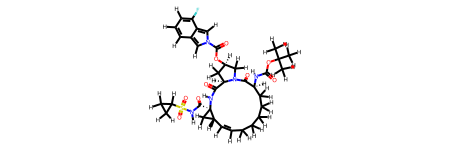

In [47]:
standardized_mol

In [43]:
for mol in mols[6961:6964] :
    original_smiles = Chem.MolToSmiles(mol)
    standardized_mol = Chem.MolFromSmiles(original_smiles)
    standardized_mol = Chem.AddHs(standardized_mol, addCoords=True)
    standard_smiles = Chem.MolToSmiles(standardized_mol)
    print(original_smiles == standard_smiles)

False
False
False


In [36]:
original_smiles

'[H]/[C]1=[C](\\[H])-[C@]2(-[H])-[C](-[H])(-[H])-[C@@]-2(-[C](=[O])-[N](-[H])-[S](=[O])(=[O])-[C]2(-[H])-[C](-[H])(-[H])-[C]-2(-[H])-[H])-[N](-[H])-[C](=[O])-[C@@]2(-[H])-[N](-[C](=[O])-[C@@](-[H])(-[N](-[H])-[C](=[O])-[O]-[C](-[C](-[H])(-[H])-[H])(-[C](-[H])(-[H])-[H])-[C](-[H])(-[H])-[H])-[C](-[H])(-[H])-[C](-[H])(-[H])-[C](-[H])(-[H])-[C](-[H])(-[H])-[C]-1(-[H])-[H])-[C](-[H])(-[H])-[C@](-[H])(-[O]-[C](=[O])-[n]1:[c](-[H]):[c]3:[c](-[H]):[c](-[H]):[c](-[H]):[c](-[F]):[c]:3:[c]:1-[H])-[C]-2(-[H])-[H]'

In [37]:
standard_smiles

'[H]/[C]1=[C](/[H])-[C@]2(-[H])-[C](-[H])(-[H])-[C@@]-2(-[C](=[O])-[N](-[H])-[S](=[O])(=[O])-[C]2(-[H])-[C](-[H])(-[H])-[C]-2(-[H])-[H])-[N](-[H])-[C](=[O])-[C@@]2(-[H])-[N](-[C](=[O])-[C@@](-[H])(-[N](-[H])-[C](=[O])-[O]-[C](-[C](-[H])(-[H])-[H])(-[C](-[H])(-[H])-[H])-[C](-[H])(-[H])-[H])-[C](-[H])(-[H])-[C](-[H])(-[H])-[C](-[H])(-[H])-[C](-[H])(-[H])-[C]-1(-[H])-[H])-[C](-[H])(-[H])-[C@](-[H])(-[O]-[C](=[O])-[n]1:[c](-[H]):[c]3:[c](-[H]):[c](-[H]):[c](-[H]):[c](-[F]):[c]:3:[c]:1-[H])-[C]-2(-[H])-[H]'

In [21]:
for i, mol in enumerate(mols) :
    if Chem.MolToSmiles(mol) == concern_smiles :
        print(i)

6961
6962
6963


In [ ]:
'[H]/C1=C(\[H])[C@]2([H])C([H])([H])[C@@]2(C(=O)N([H])S(=O)(=O)C2([H])C([H])([H])C2([H])[H])N([H])C(=O)[C@@]2([H])N(C(=O)[C@@]([H])(N([H])C(=O)OC(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C1([H])[H])C([H])([H])[C@]([H])(OC(=O)n1c([H])c3c([H])c([H])c([H])c(F)c3c1[H])C2([H])[H]'
'[H]/C1=C(/[H])[C@]2([H])C([H])([H])[C@@]2(C(=O)N([H])S(=O)(=O)C2([H])C([H])([H])C2([H])[H])N([H])C(=O)[C@@]2([H])N(C(=O)[C@@]([H])(N([H])C(=O)OC(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C1([H])[H])C([H])([H])[C@]([H])(OC(=O)n1c([H])c3c([H])c([H])c([H])c(F)c3c1[H])C2([H])[H]'

In [ ]:
'[H]/C1=C(\[H])[C@]2([H])C([H])([H])[C@@]2(C(=O)N([H])S(=O)(=O)C2([H])C([H])([H])C2([H])[H])N([H])C(=O)[C@@]2([H])N(C(=O)[C@@]([H])(N([H])C(=O)OC(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C1([H])[H])C([H])([H])[C@]([H])(OC(=O)n1c([H])c3c([H])c([H])c([H])c(F)c3c1[H])C2([H])[H]'

In [21]:
Chem.MolToSmiles(ConformationEnsemble(mols[6962]).mol)

'[H]/C1=C(/[H])[C@]2([H])C([H])([H])[C@@]2(C(=O)N([H])S(=O)(=O)C2([H])C([H])([H])C2([H])[H])N([H])C(=O)[C@@]2([H])N(C(=O)[C@@]([H])(N([H])C(=O)OC(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C1([H])[H])C([H])([H])[C@]([H])(OC(=O)n1c([H])c3c([H])c([H])c([H])c(F)c3c1[H])C2([H])[H]'

In [17]:
Chem.MolToSmiles(ConformationEnsemble(mols[6961]).mol)

'[H]/C1=C(/[H])[C@]2([H])C([H])([H])[C@@]2(C(=O)N([H])S(=O)(=O)C2([H])C([H])([H])C2([H])[H])N([H])C(=O)[C@@]2([H])N(C(=O)[C@@]([H])(N([H])C(=O)OC(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C1([H])[H])C([H])([H])[C@]([H])(OC(=O)n1c([H])c3c([H])c([H])c([H])c(F)c3c1[H])C2([H])[H]'

In [3]:
smiles = 'CC(=O)NC1=CC=C(C=C1)O'
mols = [Chem.MolFromSmiles(smiles) for _ in range(2)]

In [7]:
EmbedMolecule(mols[0])

0

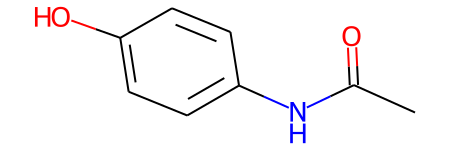

In [8]:
mols[0]

In [11]:
Chem.MolToSmiles(Chem.AddHs(mols[0], addCoords=True))

'[H]Oc1c([H])c([H])c(N([H])C(=O)C([H])([H])[H])c([H])c1[H]'